# Convergence metrics evaluated on Leela

In [47]:
from leela_logit_lens.tools.sample_positions import sample_unique_positions
from leela_interp import Lc0sight, LeelaBoard
from leela_logit_lens import LeelaLogitLens
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.spatial.distance import jensenshannon
import leela_interp.tools.figure_helpers as fh
import scipy.stats as st

Initialize model and sample positions.

In [198]:
boards = sample_unique_positions(directory="../data/cclr/train", total_samples=1000, seed=42)
model = Lc0sight("../lc0-original.onnx")
lens = LeelaLogitLens(model)
results = lens.multi_layer_lens(boards=boards, output="policy", return_probs=True, return_policy_as_dict=True)

Using device: cpu


/Users/hartig/PycharmProjects/leela-logit-lens-paper/venv/lib/python3.13/site-packages/onnx2torch/node_converters/slice.py:63: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/python_variable_indexing.cpp:312.)
  x = x[pos_axes_slices]


In [280]:
# Style configuration
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 20,
    "font.size": 11,
    "legend.fontsize": 20,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "figure.figsize": (7, 5),
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05
})

In [268]:
PLOT_FACE_COLOR = fh.PLOT_FACE_COLOR
ERROR_ALPHA = 0.3
LINE_WIDTH = 2
COLORS = ['#0173B2', '#CC78BC', '#D55E00', '#009E73']

In [201]:
def plot_metric(data_array, ylabel, save_path, reference_lines=None, ylim=(None,1)):
    """
    Generic plotting function for any metric.
    
    Args:
        data_array: numpy array of trajectories
        ylabel: y-axis label
        save_path: path to save the figure
        reference_lines: list of (y_value, color, alpha) tuples for reference lines
    """
    median_vals = np.median(data_array, axis=0)
    q25 = np.percentile(data_array, 25, axis=0)
    q75 = np.percentile(data_array, 75, axis=0)
    q10 = np.percentile(data_array, 5, axis=0)
    q90 = np.percentile(data_array, 95, axis=0)
    
    num_layers = len(median_vals)
    
    # Create x-tick labels: Input, 0, 1, 2, ..., Final
    x_tick_labels = []
    for i in range(num_layers):
        if i == 0:
            x_tick_labels.append("Input")
        elif i == num_layers - 1:
            x_tick_labels.append("Final")
        else:
            x_tick_labels.append(str(i - 1))
    
    # Create figure
    fig, ax = plt.subplots()
    
    # Plot median line
    ax.plot(range(num_layers), median_vals, 
            color=COLORS[0], linewidth=LINE_WIDTH, label='Median')
    
    # Fill between 10th and 90th percentiles (lighter)
    ax.fill_between(range(num_layers), 
                    q10, q90, 
                    alpha=ERROR_ALPHA * 0.4,  # Lighter alpha
                    color=COLORS[0], 
                    label='10th-90th percentile')
    
    # Fill between 25th and 75th percentiles (darker)
    ax.fill_between(range(num_layers), 
                    q25, q75, 
                    alpha=ERROR_ALPHA, 
                    color=COLORS[0],
                    label='25th-75th percentile')
    
    # Formatting
    ax.set_xlabel('Layer')
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, num_layers - 1)
    ax.set_ylim(ylim)
    
    # Set x-ticks
    if num_layers <= 8:
        ax.set_xticks(range(num_layers))
        ax.set_xticklabels(x_tick_labels)
    else:
        step = max(1, num_layers // 5)
        selected_ticks = list(range(0, num_layers, step))
        if num_layers - 1 not in selected_ticks:
            selected_ticks.append(num_layers - 1)
        ax.set_xticks(selected_ticks)
        ax.set_xticklabels([x_tick_labels[i] for i in selected_ticks])
    
    # Styling
    ax.spines[:].set_visible(False)
    ax.set_facecolor(PLOT_FACE_COLOR)
    ax.grid(linestyle="--")
    ax.grid(which="minor", alpha=0.3, linestyle="--")
    
    # Add reference lines if specified
    if reference_lines:
        for y_val, color, alpha in reference_lines:
            ax.axhline(y=y_val, color=color, linestyle='--', alpha=alpha)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    return fig, ax

## JS-divergence

In [202]:
def compute_js_divergence_trajectories(results, model):
    """Compute Jensen-Shannon divergence trajectories for all boards."""
    layer_indices = sorted(results[0]["layers"].keys())
    final_layer_idx = max(layer_indices)
    all_trajectories = []
    
    for board_result in results:
        board = board_result["board"]
        legal_indices, _ = model.legal_moves(board)
        legal_indices = torch.tensor(legal_indices, device=model.device)
        
        final_policy = board_result["layers"][final_layer_idx]["policy"]
        final_probs = final_policy[legal_indices].cpu().numpy()
        final_probs = final_probs / final_probs.sum()
        
        js_trajectory = []
        for layer_idx in layer_indices:
            layer_policy = board_result["layers"][layer_idx]["policy"]
            layer_probs = layer_policy[legal_indices].cpu().numpy()
            layer_probs = layer_probs / layer_probs.sum()
            js_div = jensenshannon(layer_probs, final_probs, base=2)
            js_trajectory.append(js_div)
        
        all_trajectories.append(js_trajectory)
    
    return np.array(all_trajectories)

In [203]:
js_data = compute_js_divergence_trajectories(results, model)

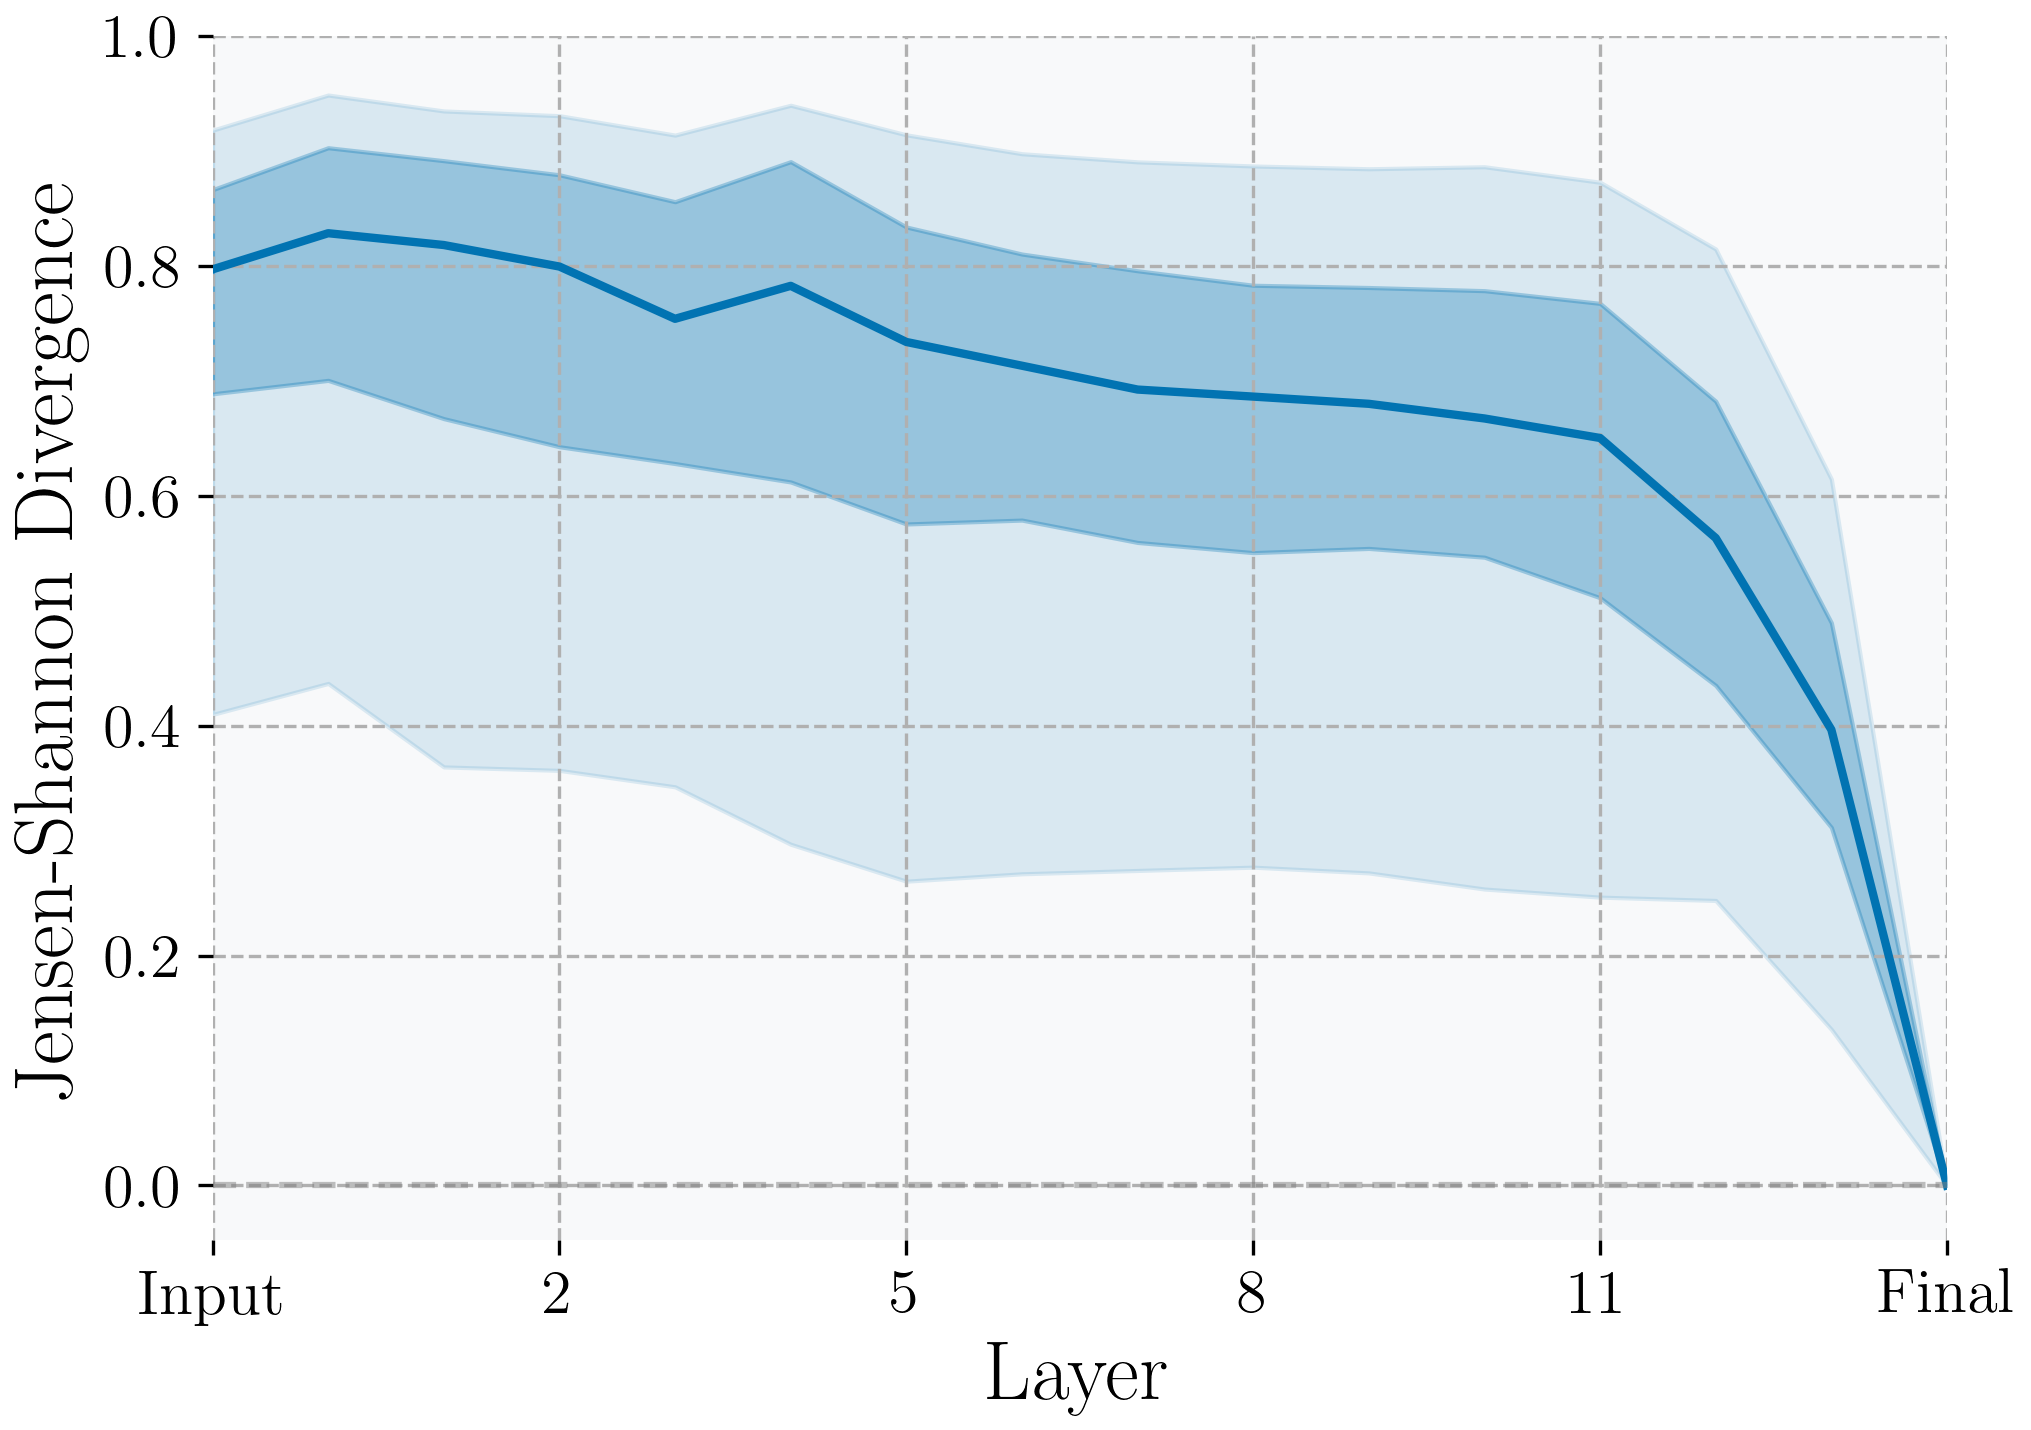

(<Figure size 2100x1500 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Jensen-Shannon Divergence'>)

In [204]:
plot_metric(js_data, 
            ylabel="Jensen-Shannon Divergence",
            save_path="Figures/js_divergence.pdf",
            reference_lines=[(0.0, 'gray', 0.5)])

## Entropy

In [205]:
def compute_entropy_trajectories(results, model):
    """Compute normalized entropy trajectories for all boards."""
    layer_indices = sorted(results[0]["layers"].keys())
    all_trajectories = []
    
    for board_result in results:
        board = board_result["board"]
        legal_indices, _ = model.legal_moves(board)
        legal_indices = torch.tensor(legal_indices, device=model.device)
        
        if len(legal_indices) < 2:
            continue
        
        num_legal_moves = len(legal_indices)
        entropy_trajectory = []
        
        for layer_idx in layer_indices:
            layer_policy = board_result["layers"][layer_idx]["policy"]
            layer_legal_probs = layer_policy[legal_indices].cpu().numpy()
            layer_legal_probs = layer_legal_probs / np.sum(layer_legal_probs)
            
            entropy = -np.sum(layer_legal_probs * np.log2(layer_legal_probs + 1e-12))
            max_entropy = np.log2(num_legal_moves)
            normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0.0
            entropy_trajectory.append(normalized_entropy)
        
        all_trajectories.append(entropy_trajectory)
    
    return np.array(all_trajectories)

In [206]:
entropy_data = compute_entropy_trajectories(results, model)

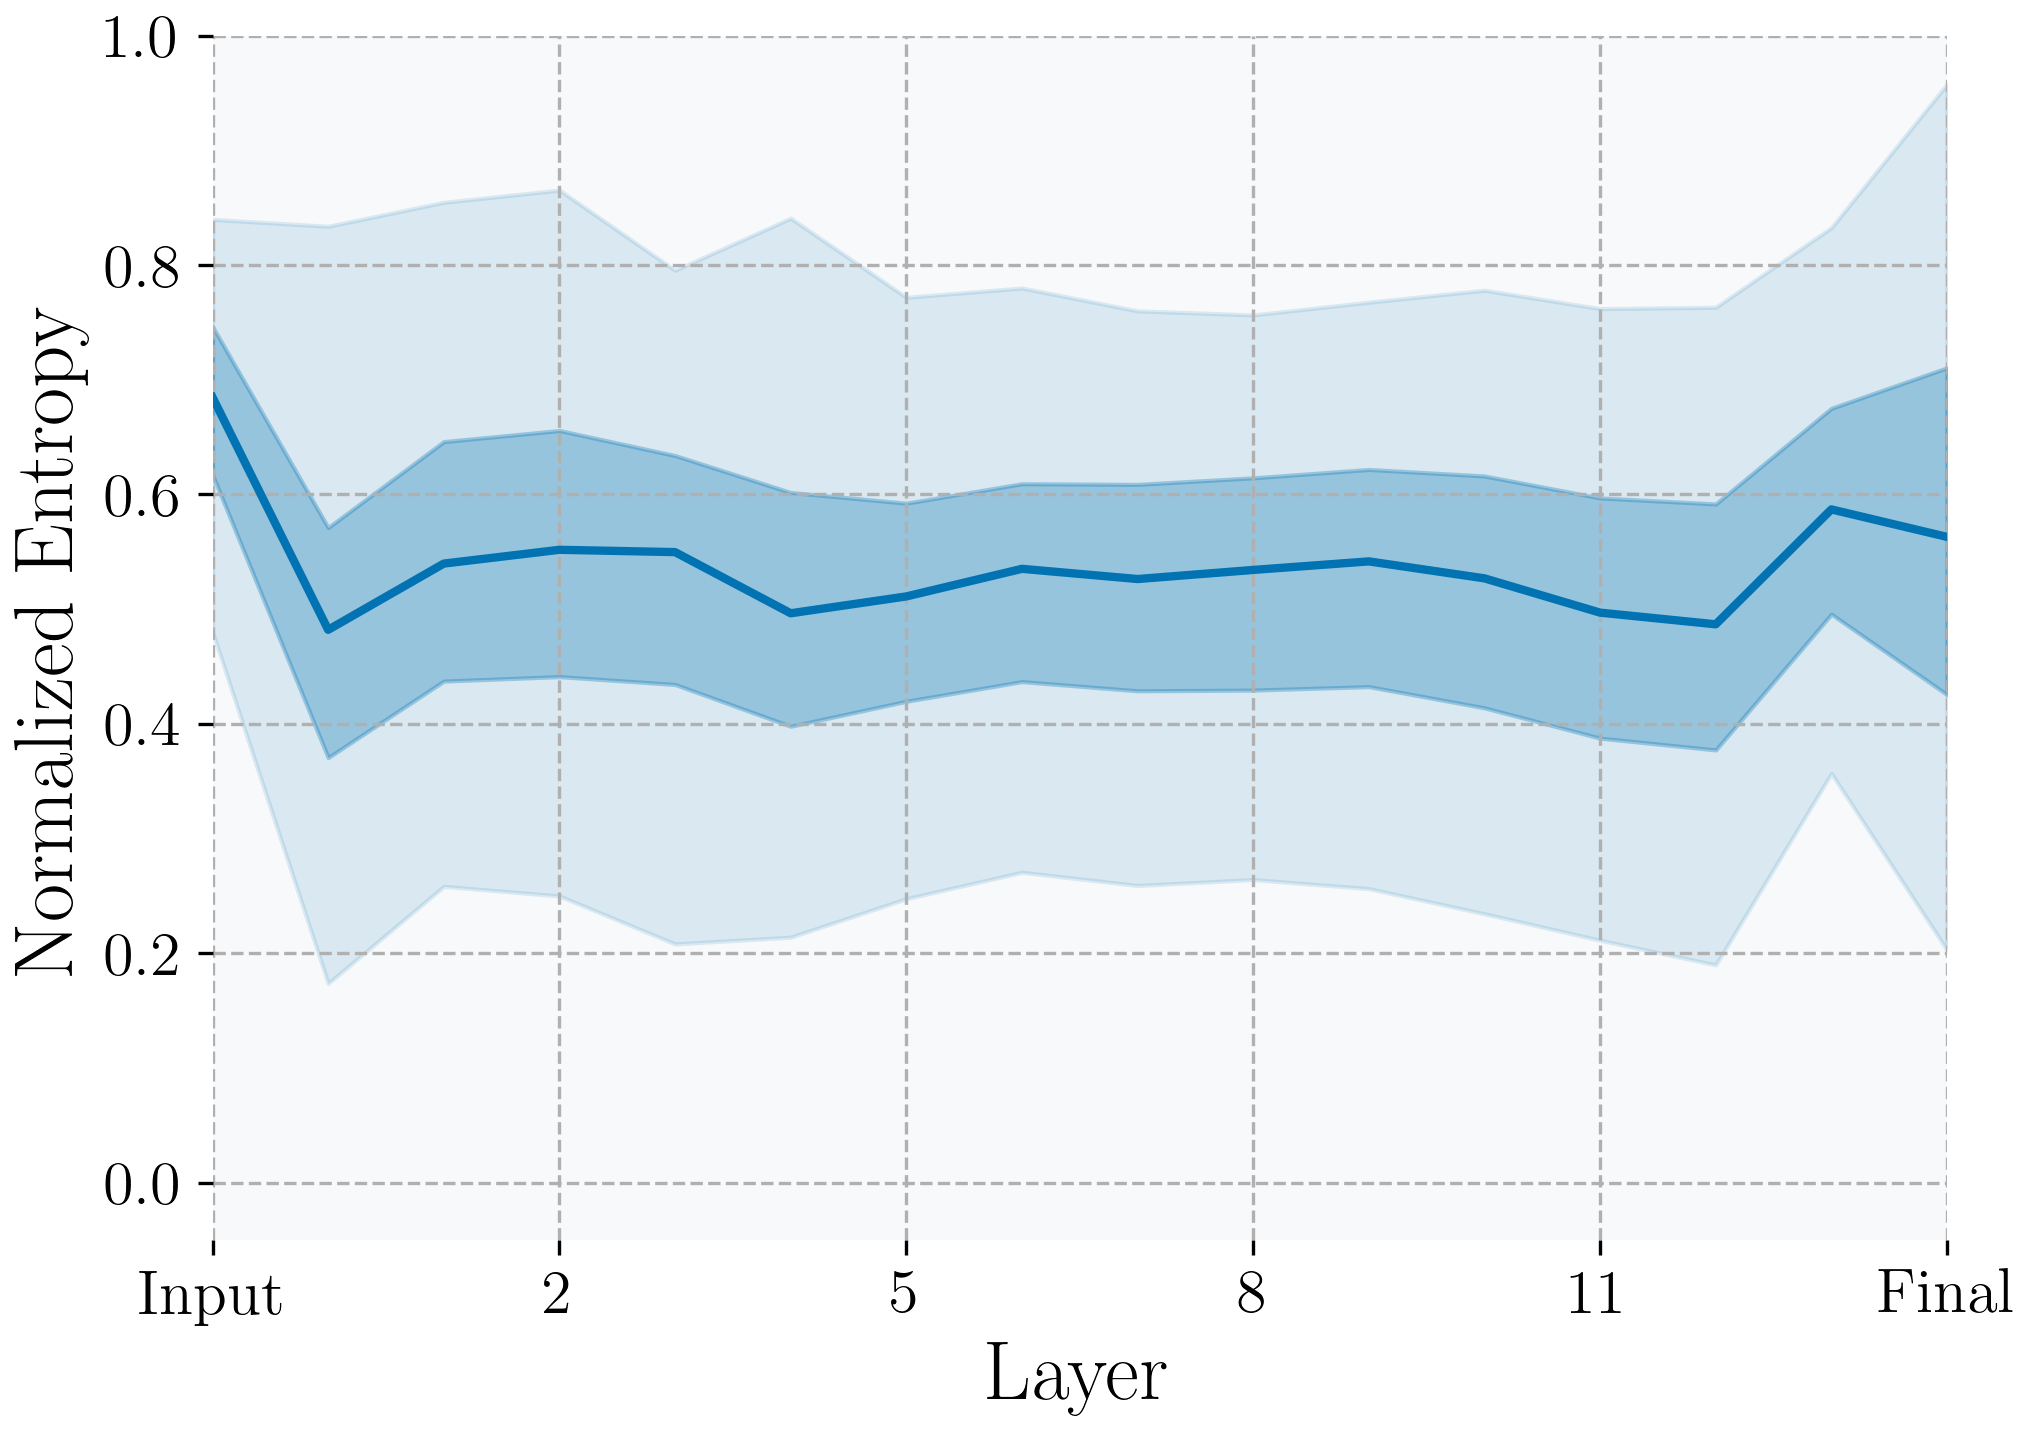

(<Figure size 2100x1500 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Normalized Entropy'>)

In [220]:
plot_metric(entropy_data,
            ylabel="Normalized Entropy", 
            save_path="Figures/entropy.pdf",
           ylim=(-0.05,1))

## Kendalls tau ranking correlation (all moves)

In [208]:
def compute_tau_trajectories(results, model):
    """Compute Kendall's tau trajectories for all boards."""
    if not results:
        return np.array([])
    
    num_layers = len(results[0]["layers"])
    layer_indices = sorted(results[0]["layers"].keys())
    final_layer_idx = max(layer_indices)
    layer_taus = [[] for _ in range(num_layers)]
    
    for board_result in results:
        board = board_result["board"]
        legal_indices, _ = model.legal_moves(board)
        legal_indices = torch.tensor(legal_indices, device=model.device)
        
        if len(legal_indices) < 3:
            continue
        
        final_policy = board_result["layers"][final_layer_idx]["policy"]
        final_legal_probs = final_policy[legal_indices]
        final_ranking = final_legal_probs.argsort(descending=True)
        
        for i, layer_idx in enumerate(layer_indices):
            layer_policy = board_result["layers"][layer_idx]["policy"]
            layer_legal_probs = layer_policy[legal_indices]
            layer_ranking = layer_legal_probs.argsort(descending=True)
            
            final_positions = torch.zeros_like(final_ranking)
            layer_positions = torch.zeros_like(layer_ranking)
            
            for rank, move_idx in enumerate(final_ranking):
                final_positions[move_idx] = rank
            for rank, move_idx in enumerate(layer_ranking):
                layer_positions[move_idx] = rank
            
            tau = st.kendalltau(
                layer_positions.cpu().numpy(),
                final_positions.cpu().numpy(),
                variant="b"
            ).correlation
            
            if not np.isnan(tau):
                layer_taus[i].append(tau)
    
    # Convert to trajectories format
    all_trajectories = []
    num_valid_boards = len(layer_taus[0]) if layer_taus[0] else 0
    
    for board_idx in range(num_valid_boards):
        tau_trajectory = []
        for layer_idx in range(num_layers):
            if board_idx < len(layer_taus[layer_idx]):
                tau_trajectory.append(layer_taus[layer_idx][board_idx])
            else:
                tau_trajectory.append(0.0)
        all_trajectories.append(tau_trajectory)
    
    return np.array(all_trajectories)

In [209]:
tau_data = compute_tau_trajectories(results, model)

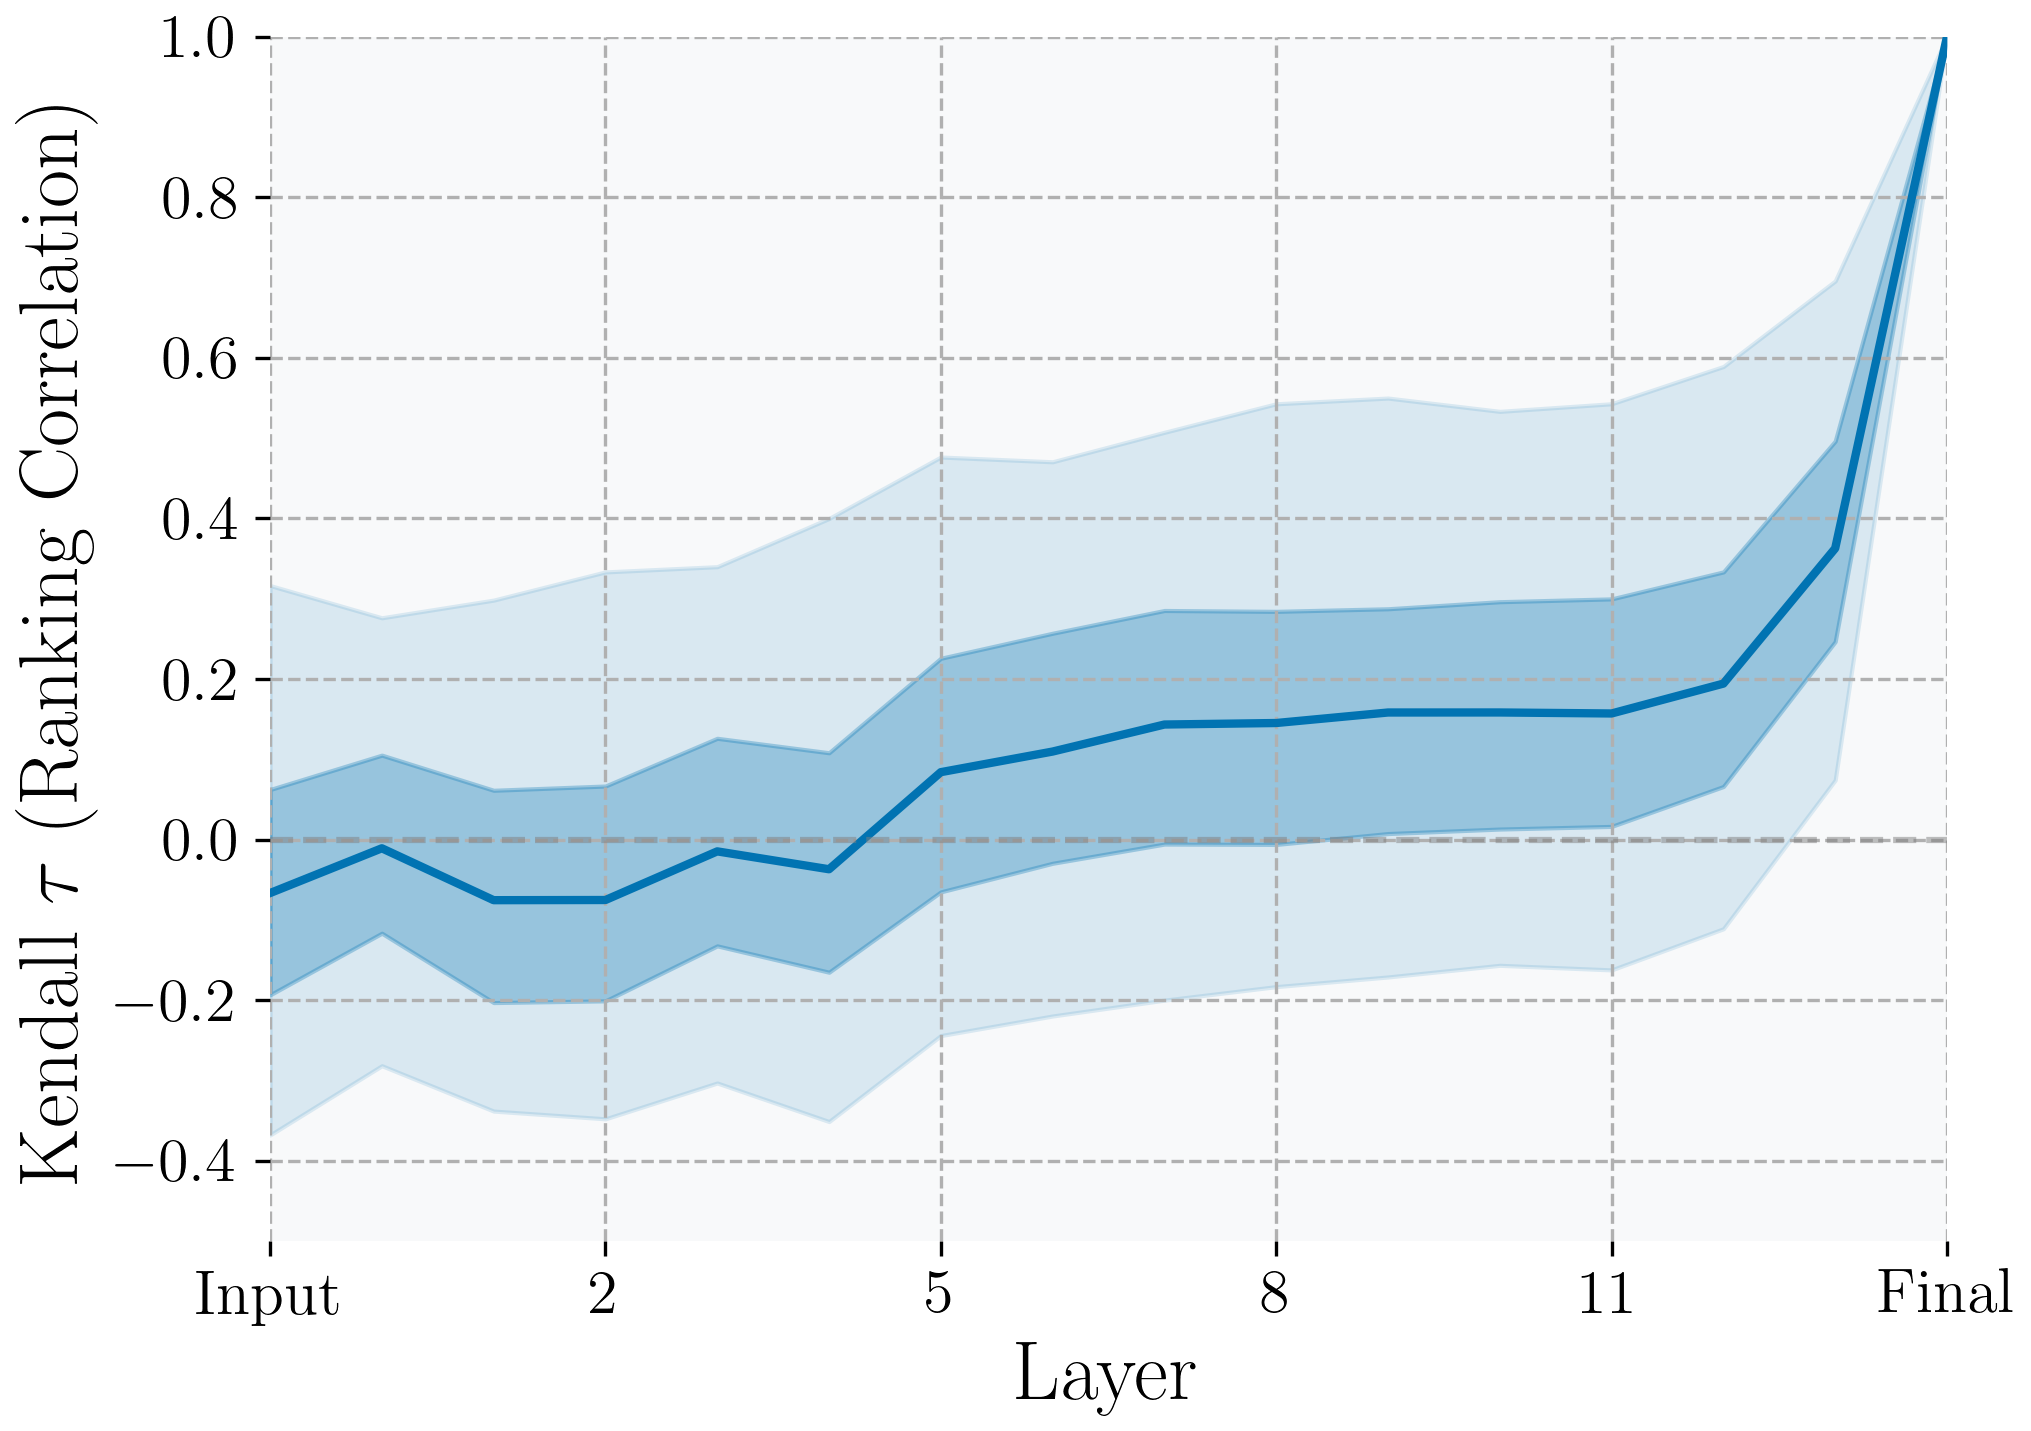

(<Figure size 2100x1500 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Kendall $\\tau$ (Ranking Correlation)'>)

In [267]:
plot_metric(tau_data,
            ylabel=r"Kendall $\tau$ (Ranking Correlation)",
            save_path="Figures/tau_correlation.pdf",
            reference_lines=[(0.0, 'gray', 0.5)],
            ylim=(-0.5,1))

## Kendalls tau ranking correlation (top-5 moves)
To mitigate noise from low probability moves that are never considered we also plot the $\tau$ ranking correlation using only moves that were under the top-5 considered moves for any layer. 

In [223]:
def compute_tau_top5_trajectories(results, model):
    """Compute Kendall's tau trajectories using only top-5 moves."""
    if not results:
        return np.array([])
    
    num_layers = len(results[0]["layers"])
    layer_indices = sorted(results[0]["layers"].keys())
    final_layer_idx = max(layer_indices)
    layer_taus = [[] for _ in range(num_layers)]
    
    for board_result in results:
        board = board_result["board"]
        legal_indices, _ = model.legal_moves(board)
        legal_indices = torch.tensor(legal_indices, device=model.device)
        
        if len(legal_indices) < 2:
            continue
        
        # Find all moves that appear in top-5 of any layer
        top5_moves_set = set()
        for layer_idx in layer_indices:
            layer_policy = board_result["layers"][layer_idx]["policy"]
            layer_legal_probs = layer_policy[legal_indices]
            top5_indices = layer_legal_probs.argsort(descending=True)[:5]
            for idx in top5_indices:
                top5_moves_set.add(idx.item())
        
        top5_moves_list = sorted(list(top5_moves_set))
        if len(top5_moves_list) < 2:
            continue
        
        # Get final layer ranking for top-5 moves only
        final_policy = board_result["layers"][final_layer_idx]["policy"]
        final_legal_probs = final_policy[legal_indices]
        final_top5_probs = final_legal_probs[top5_moves_list]
        final_ranking = final_top5_probs.argsort(descending=True)
        
        # Compute tau for each layer using only top-5 moves
        for i, layer_idx in enumerate(layer_indices):
            layer_policy = board_result["layers"][layer_idx]["policy"]
            layer_legal_probs = layer_policy[legal_indices]
            layer_top5_probs = layer_legal_probs[top5_moves_list]
            layer_ranking = layer_top5_probs.argsort(descending=True)
            
            final_positions = torch.zeros_like(final_ranking)
            layer_positions = torch.zeros_like(layer_ranking)
            
            for rank, move_idx in enumerate(final_ranking):
                final_positions[move_idx] = rank
            for rank, move_idx in enumerate(layer_ranking):
                layer_positions[move_idx] = rank
            
            tau = st.kendalltau(
                layer_positions.cpu().numpy(),
                final_positions.cpu().numpy(),
                variant="b"
            ).correlation
            
            if not np.isnan(tau):
                layer_taus[i].append(tau)
    
    # Convert to trajectories format
    all_trajectories = []
    num_valid_boards = len(layer_taus[0]) if layer_taus[0] else 0
    
    for board_idx in range(num_valid_boards):
        tau_trajectory = []
        for layer_idx in range(num_layers):
            if board_idx < len(layer_taus[layer_idx]):
                tau_trajectory.append(layer_taus[layer_idx][board_idx])
            else:
                tau_trajectory.append(0.0)
        all_trajectories.append(tau_trajectory)
    
    return np.array(all_trajectories)

In [224]:
tau_top5_data = compute_tau_top5_trajectories(results, model)

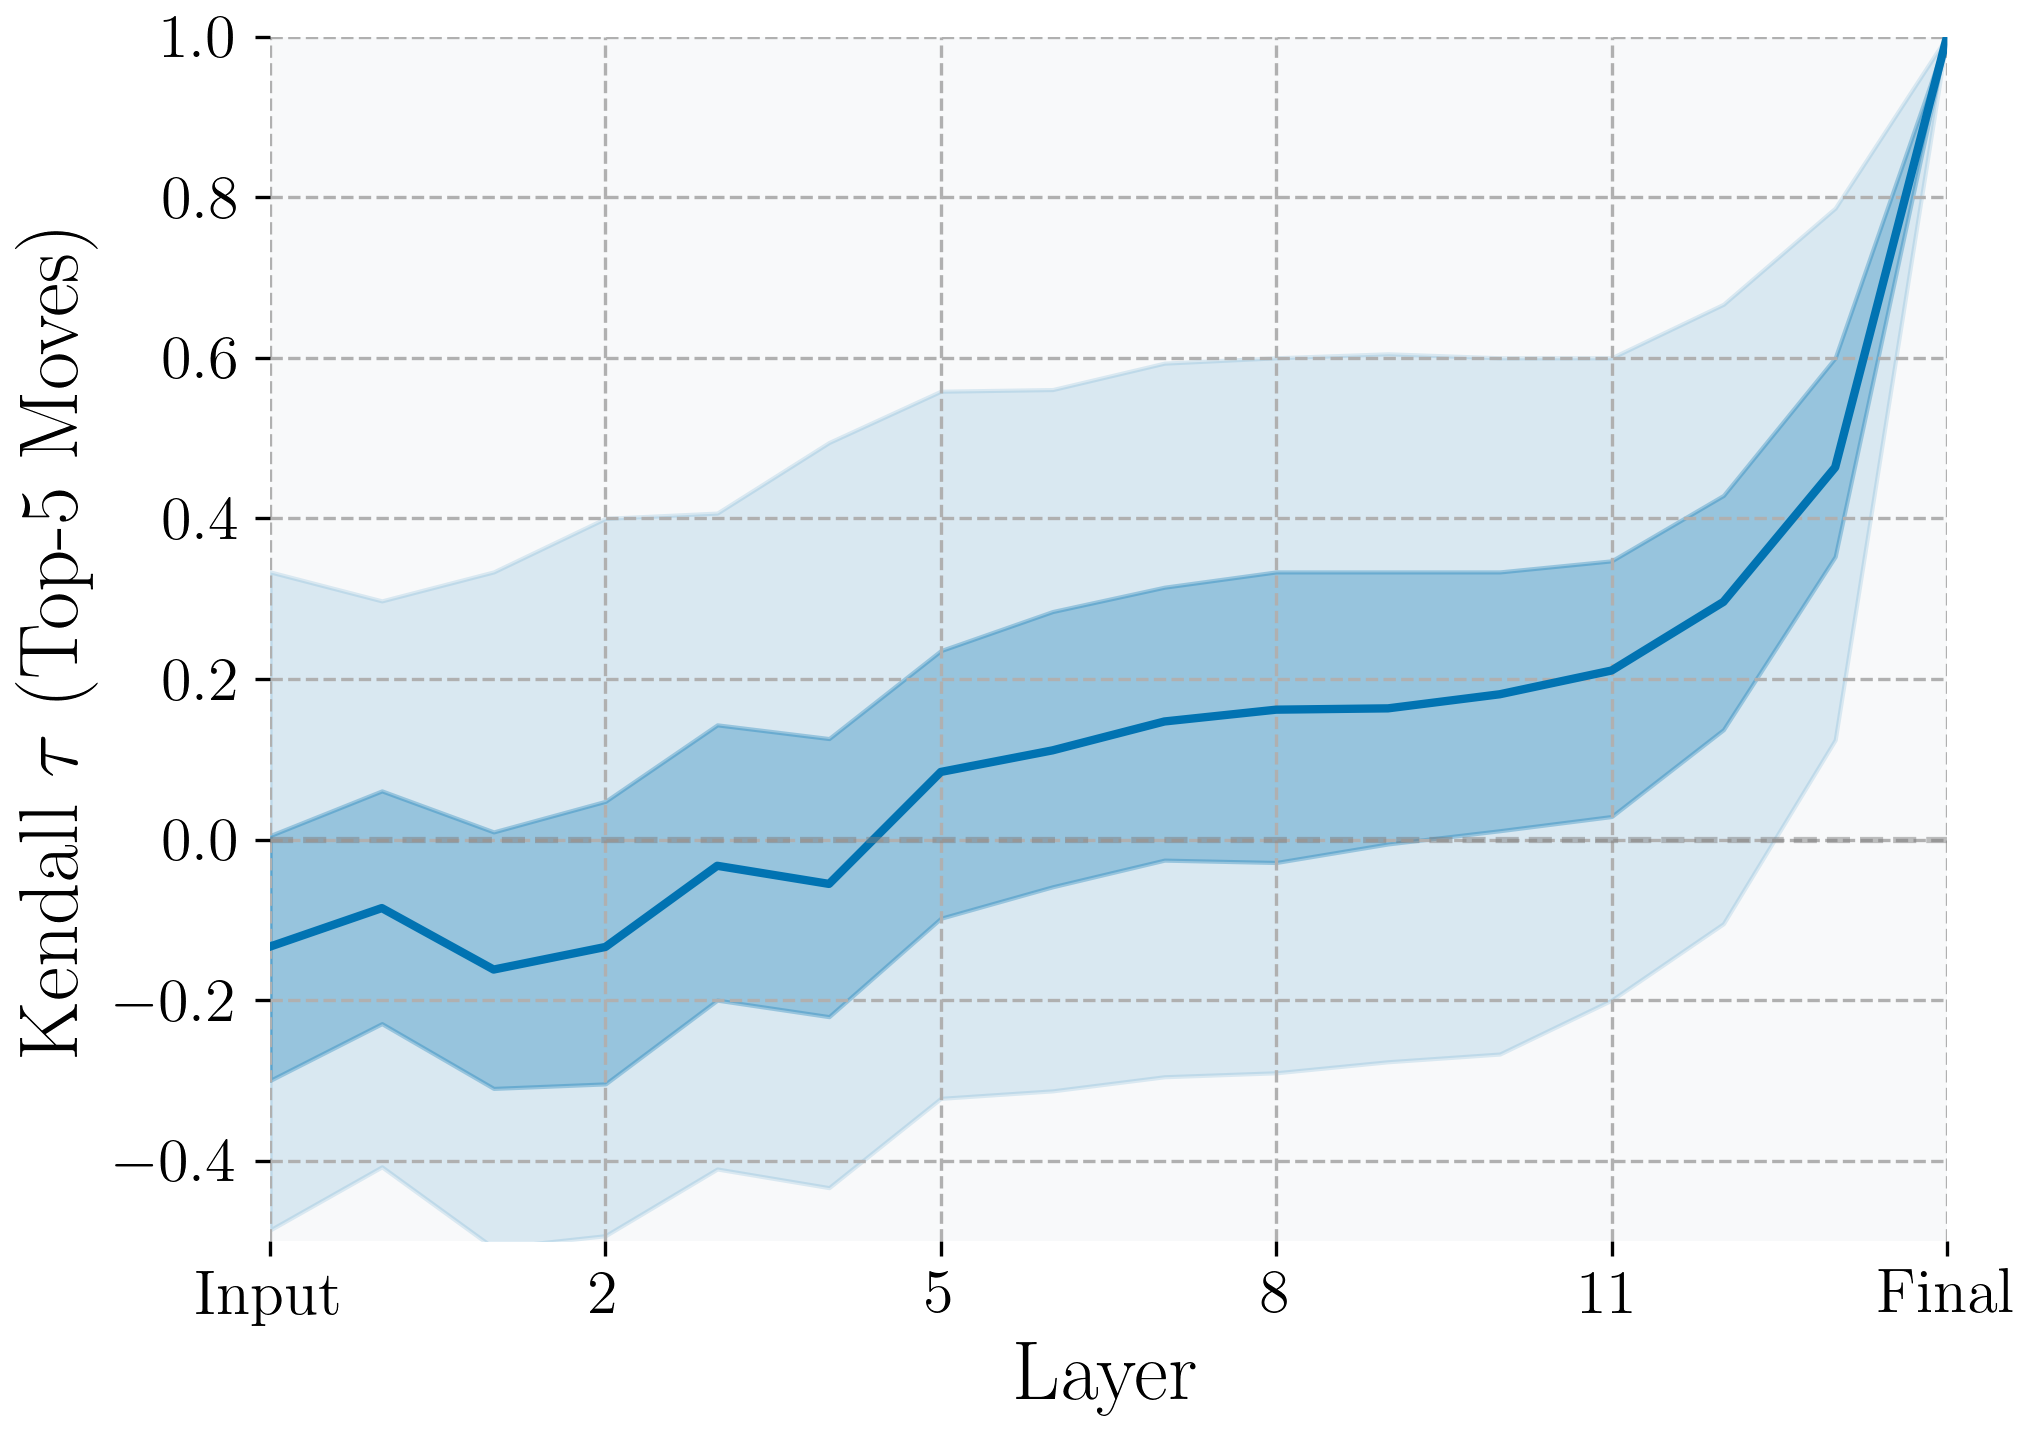

(<Figure size 2100x1500 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Kendall $\\tau$ (Top-5 Moves)'>)

In [266]:
plot_metric(tau_top5_data,
            ylabel=r"Kendall $\tau$ (Top-5 Moves)",
            save_path="Figures/tau_top5.pdf",
            reference_lines=[(0.0, 'gray', 0.5)],
            ylim=(-0.5,1))

## Probability of top-prediction from full model
Here we plot the probability intermediate layers place on the move that will be considered as the best one by the complete model. 

In [214]:
def compute_top_prediction_trajectories(results, model):
    """Compute top prediction probability trajectories for all boards."""
    layer_indices = sorted(results[0]["layers"].keys())
    final_layer_idx = max(layer_indices)
    all_trajectories = []
    
    for board_result in results:
        board = board_result["board"]
        legal_indices, _ = model.legal_moves(board)
        legal_indices = torch.tensor(legal_indices, device=model.device)
        
        if len(legal_indices) < 2:
            continue
        
        final_policy = board_result["layers"][final_layer_idx]["policy"]
        final_legal_probs = final_policy[legal_indices]
        top_move_idx = torch.argmax(final_legal_probs)
        
        prob_trajectory = []
        for layer_idx in layer_indices:
            layer_policy = board_result["layers"][layer_idx]["policy"]
            layer_legal_probs = layer_policy[legal_indices]
            top_move_prob = layer_legal_probs[top_move_idx].cpu().numpy()
            prob_trajectory.append(float(top_move_prob))
        
        all_trajectories.append(prob_trajectory)
    
    return np.array(all_trajectories)

In [215]:
top_pred_data = compute_top_prediction_trajectories(results, model)

In [222]:
top_pred_data.shape

(994, 16)

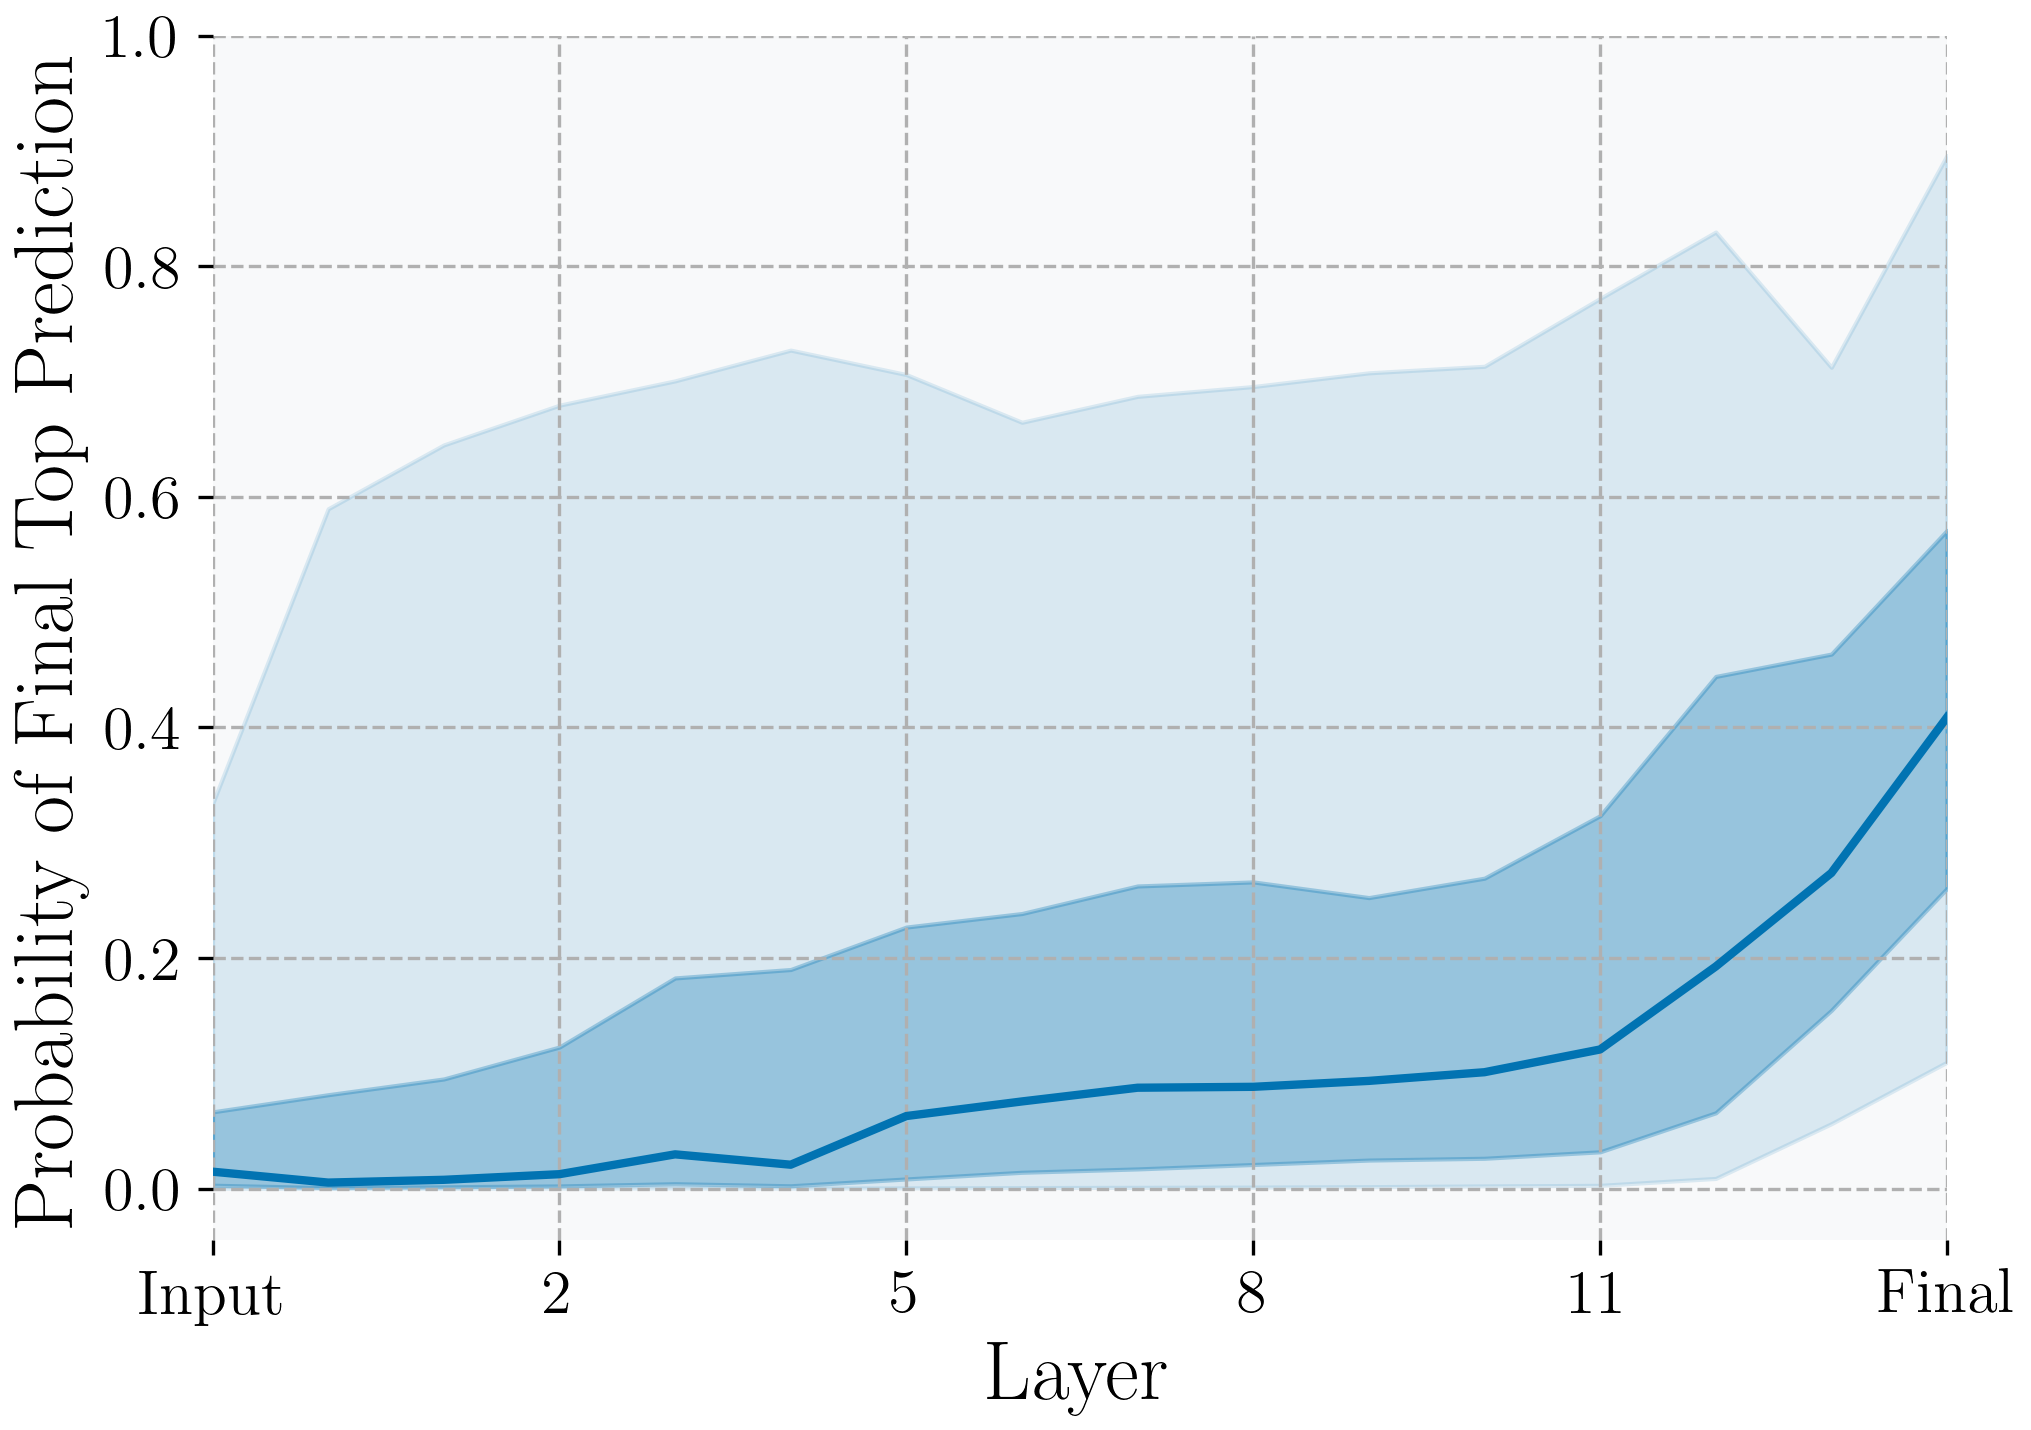

(<Figure size 2100x1500 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Probability of Final Top Prediction'>)

In [216]:
plot_metric(top_pred_data,
            ylabel="Probability of Final Top Prediction",
            save_path="Figures/top_prediction_prob.pdf")

### MLP output norm
Similar to the stages of inference paper we plot the MLP output norm.

In [227]:
from leela_interp import ActivationCache

In [228]:
cache = ActivationCache.capture(
    boards=boards,
    names=[f'mlp_output.{i}' for i in range(model.N_LAYERS)],
    n_samples=len(boards),
    model=model,
    batch_size=16, 
    path=None,
    store_boards=False,
    pbar="tqdm",
    overwrite=True
)   

  0%|                                                      | 0/63 [00:00<?, ?it/s]/Users/hartig/PycharmProjects/leela-logit-lens-paper/venv/lib/python3.13/site-packages/onnx2torch/node_converters/slice.py:63: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/python_variable_indexing.cpp:312.)
  x = x[pos_axes_slices]
100%|█████████████████████████████████████████████| 63/63 [00:26<00:00,  2.33it/s]


In [229]:
cache.names

('mlp_output.0',
 'mlp_output.1',
 'mlp_output.10',
 'mlp_output.11',
 'mlp_output.12',
 'mlp_output.13',
 'mlp_output.14',
 'mlp_output.2',
 'mlp_output.3',
 'mlp_output.4',
 'mlp_output.5',
 'mlp_output.6',
 'mlp_output.7',
 'mlp_output.8',
 'mlp_output.9')

In [233]:
def compute_mlp_output_norm_trajectories(cache):
    """
    Compute MLP output norm trajectories across layers.
    Vectorized version for much faster computation.
    
    Args:
        cache: ActivationCache containing mlp_output activations
        
    Returns:
        numpy array of shape (total_measurements, num_layers) where each row 
        is one sample/token's norm values across all layers
    """
    # Get layer names and sort them properly by layer index
    mlp_names = [name for name in cache.names if name.startswith('mlp_output.')]
    mlp_names_sorted = sorted(mlp_names, key=lambda x: int(x.split('.')[-1]))
    
    if not mlp_names_sorted:
        raise ValueError("No mlp_output activations found in cache")
    
    # Get dimensions from first layer
    first_activations = cache[mlp_names_sorted[0]]
    if hasattr(first_activations, 'cpu'):
        first_activations = first_activations.cpu().numpy()
    
    n_samples, n_tokens, hidden_dim = first_activations.shape
    num_layers = len(mlp_names_sorted)
    
    print(f"Processing {n_samples} samples, {n_tokens} tokens per sample, {num_layers} layers")
    
    # Pre-allocate the result array
    all_norm_trajectories = np.zeros((n_samples * n_tokens, num_layers))
    
    # Vectorized computation: process all layers at once
    for layer_idx, name in enumerate(mlp_names_sorted):
        activations = cache[name]
        if hasattr(activations, 'cpu'):
            activations = activations.cpu().numpy()
        
        # Compute norms for all samples and tokens at once
        # activations shape: (n_samples, n_tokens, hidden_dim)
        norms = np.linalg.norm(activations, axis=-1)  # Shape: (n_samples, n_tokens)
        
        # Flatten and store in the result array
        all_norm_trajectories[:, layer_idx] = norms.flatten()
    
    return all_norm_trajectories

In [250]:
def plot_mlp_metric(data_array, ylabel, save_path, reference_lines=None, ylim=(None, None)):
    """
    Plotting function specifically for MLP metrics (no "Input" layer).
    """
    median_vals = np.median(data_array, axis=0)
    q25 = np.percentile(data_array, 25, axis=0)
    q75 = np.percentile(data_array, 75, axis=0)
    q5 = np.percentile(data_array, 5, axis=0)
    q95 = np.percentile(data_array, 95, axis=0)
    
    num_layers = len(median_vals)
    
    # Create x-tick labels: 0, 1, 2, ..., Final (no "Input")
    x_tick_labels = []
    for i in range(num_layers):
        if i == num_layers - 1:
            x_tick_labels.append("Final")
        else:
            x_tick_labels.append(str(i))
    
    # Create figure
    fig, ax = plt.subplots()
    
    # Plot median line
    ax.plot(range(num_layers), median_vals, 
            color=COLORS[0], linewidth=LINE_WIDTH)
    
    # Fill between 5th and 95th percentiles (lighter)
    ax.fill_between(range(num_layers), 
                    q5, q95, 
                    alpha=ERROR_ALPHA * 0.4,
                    color=COLORS[0])
    
    # Fill between 25th and 75th percentiles (darker)
    ax.fill_between(range(num_layers), 
                    q25, q75, 
                    alpha=ERROR_ALPHA, 
                    color=COLORS[0])
    
    # Formatting
    ax.set_xlabel('Layer')
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, num_layers - 1)
    ax.set_ylim(ylim)
    
    # Set x-ticks - ensure proper spacing to avoid collisions
    if num_layers <= 8:
        ax.set_xticks(range(num_layers))
        ax.set_xticklabels(x_tick_labels)
    else:
        # For longer sequences, be more careful about spacing
        step = max(1, num_layers // 4)
        selected_ticks = [0]  # Always include first layer (0)
        
        # Add intermediate ticks with less space before Final
        current = step
        while current < num_layers - 2:  # Changed from step to 2 - less space before Final
            selected_ticks.append(current)
            current += step
        
        # Always include Final (last layer)
        selected_ticks.append(num_layers - 1)
        
        ax.set_xticks(selected_ticks)
        ax.set_xticklabels([x_tick_labels[i] for i in selected_ticks])
    
    # Styling
    ax.spines[:].set_visible(False)
    ax.set_facecolor(PLOT_FACE_COLOR)
    ax.grid(linestyle="--")
    ax.grid(which="minor", alpha=0.3, linestyle="--")
    
    # Add reference lines if specified
    if reference_lines:
        for y_val, color, alpha in reference_lines:
            ax.axhline(y=y_val, color=color, linestyle='--', alpha=alpha)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    return fig, ax

In [248]:
mlp_norm_data = compute_mlp_output_norm_trajectories(cache)

Processing 1000 samples, 64 tokens per sample, 15 layers


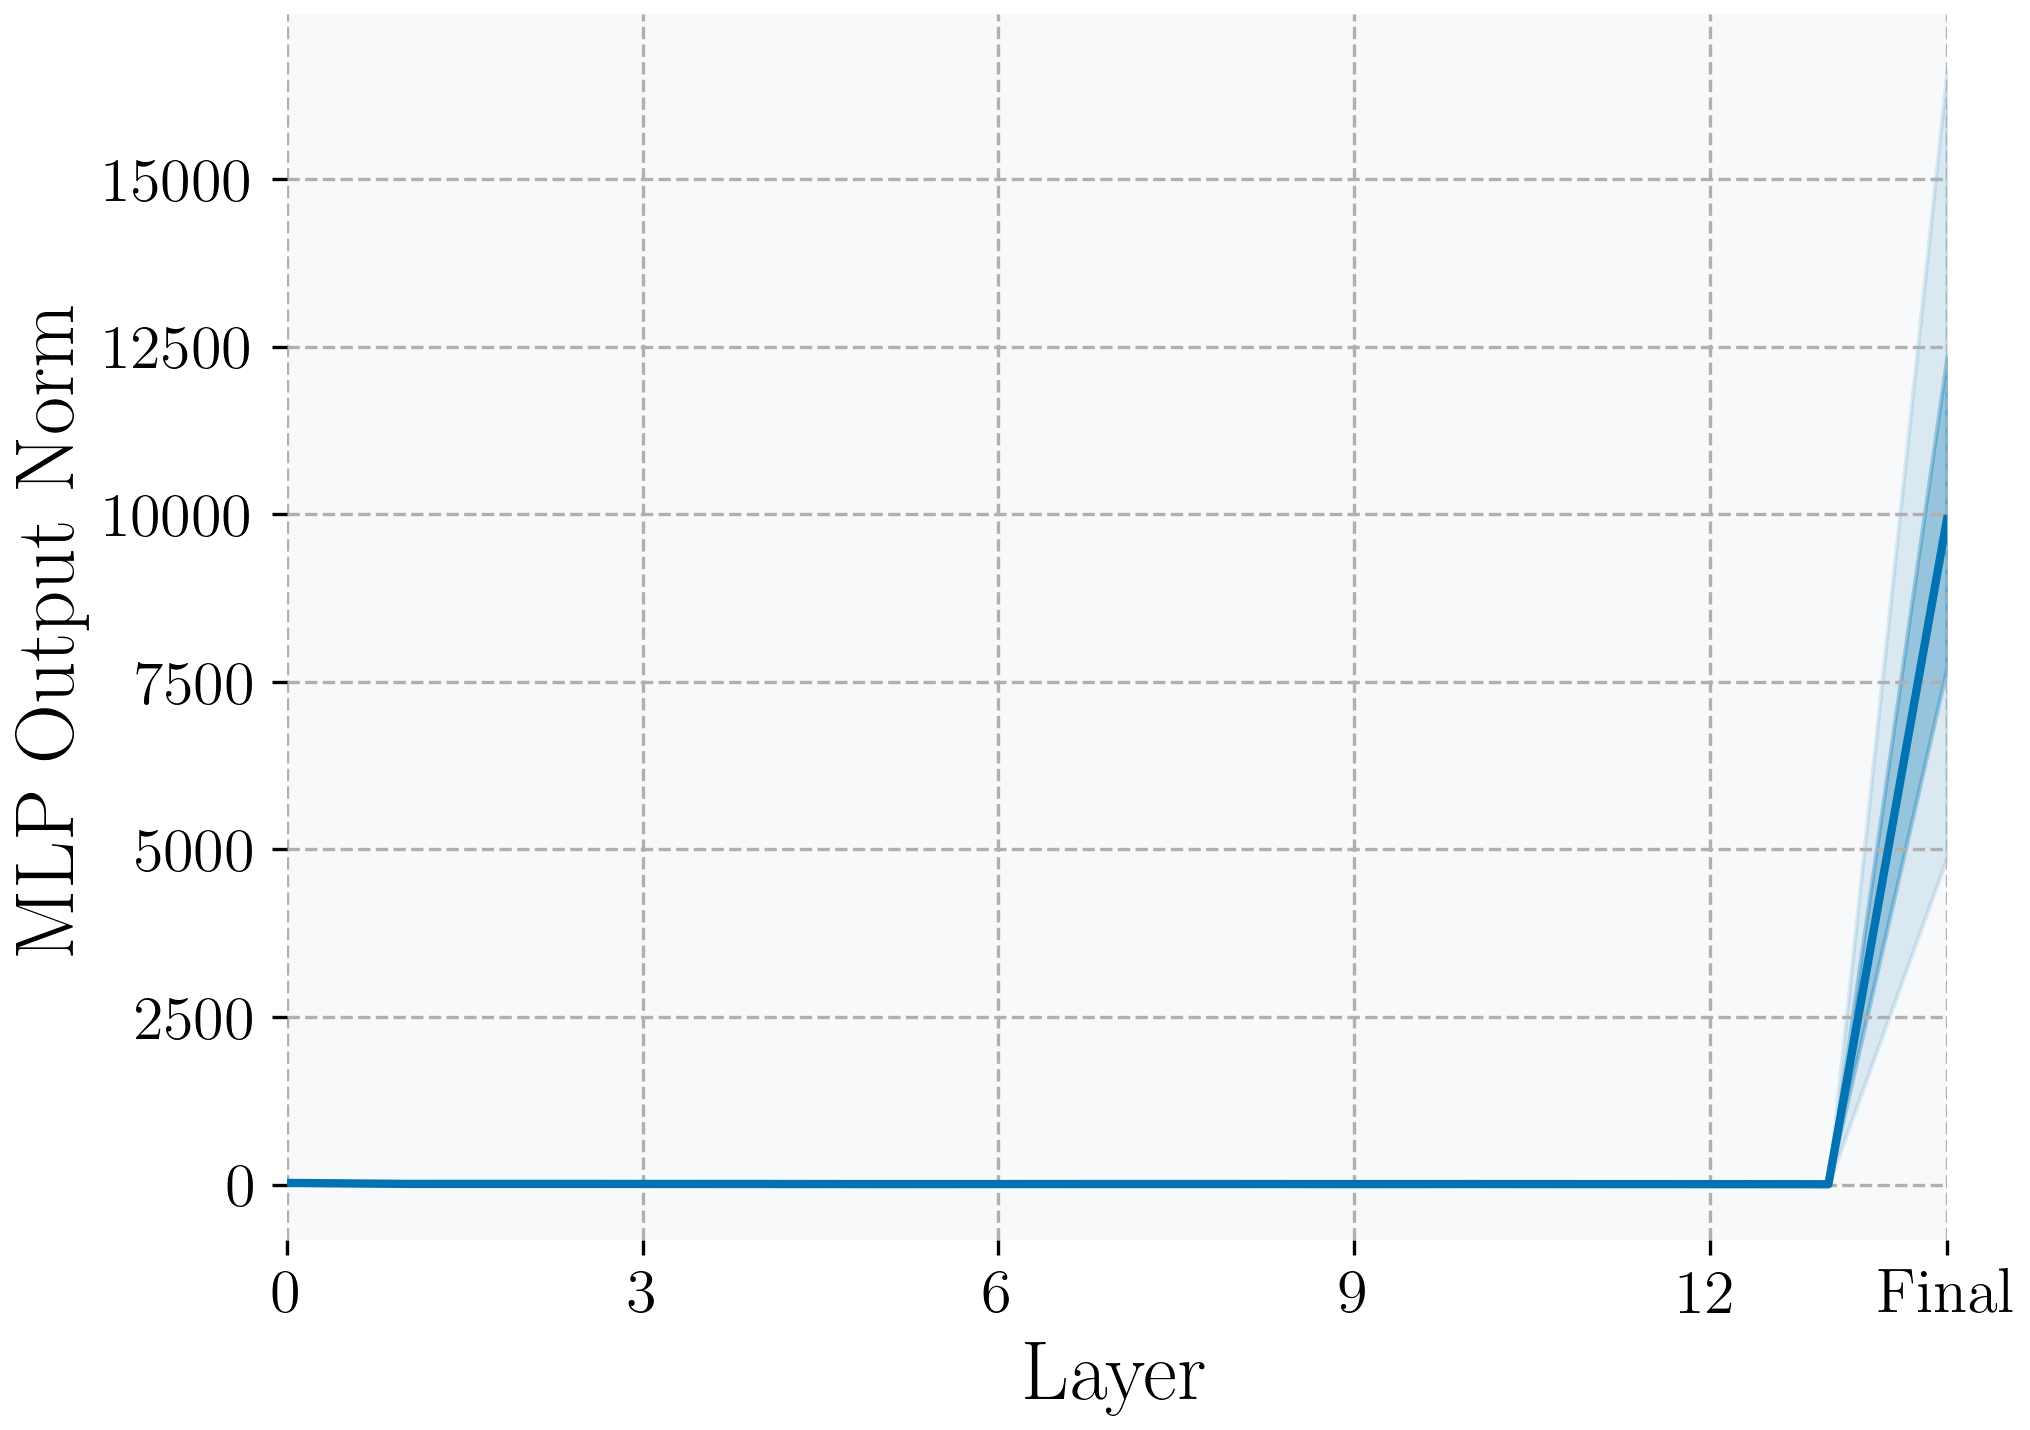

(<Figure size 2100x1500 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='MLP Output Norm'>)

In [251]:
plot_mlp_metric(
    data_array=mlp_norm_data,
    ylabel="MLP Output Norm",
    save_path="Figures/mlp_output_norms.pdf",
    reference_lines=None,  # Add reference lines if needed
    ylim=(None, None)      # Let it auto-scale or set specific limits
)

### Kendalls $\tau$ for LLMs

To filter the noise of low probability tokens we only take the tokens that got considered as one of the top-100 tokens by any layer.

In [252]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.stats as st
from tuned_lens.nn.lenses import LogitLens
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.plotting import PredictionTrajectory
from datasets import load_dataset

In [253]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [254]:
def compute_tau_for_trajectory(trajectory, top_k):
    """
    Compute Kendall's tau ranking correlation for each layer vs final layer.
    Returns all tau values for all token positions in this trajectory.
    
    Returns:
        List of arrays, where each array contains tau values across layers for one token position
    """
    all_log_probs = trajectory.log_probs
    num_layers, seq_len, vocab_size = all_log_probs.shape
    all_tau_values = []
    
    for token_pos in range(seq_len):
        token_log_probs = all_log_probs[:, token_pos, :]
        
        # Find tokens that appear in top-k of any layer
        top_k_tokens_set = set()
        for layer_idx in range(num_layers):
            layer_logits = token_log_probs[layer_idx]
            top_k_indices = np.argsort(-layer_logits)[:top_k]
            top_k_tokens_set.update(top_k_indices)
        
        top_k_tokens_list = sorted(list(top_k_tokens_set))
        if len(top_k_tokens_list) < 2:
            continue
            
        token_log_probs = token_log_probs[:, top_k_tokens_list]
        final_layer_logits = token_log_probs[-1]
        final_rankings = np.argsort(-final_layer_logits)
        
        tau_correlations = []
        for layer_idx in range(num_layers):
            layer_logits = token_log_probs[layer_idx]
            layer_rankings = np.argsort(-layer_logits)
            
            final_positions = np.zeros_like(final_rankings)
            layer_positions = np.zeros_like(layer_rankings)
            
            for rank, token_idx in enumerate(final_rankings):
                final_positions[token_idx] = rank
            for rank, token_idx in enumerate(layer_rankings):
                layer_positions[token_idx] = rank
            
            tau = st.kendalltau(layer_positions, final_positions, variant="b").correlation
            tau_correlations.append(tau if not np.isnan(tau) else 0.0)
        
        all_tau_values.append(np.array(tau_correlations))
    
    return all_tau_values

In [255]:
def analyze_single_model_tau(model_name, dataset, datapoints=10, device='cpu', top_k_filter=100):
    """
    Analyze tau correlations for a single model across multiple samples.
    
    Returns:
        numpy array where each row is one tau measurement (sample/token combination)
    """
    print(f"=== Analyzing {model_name} ===")
    
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model = model.to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    logit_lens = LogitLens.from_model(model)
    
    all_tau_measurements = []
    
    for idx, sample in enumerate(dataset.take(datapoints)):
        try:
            print(f"  Processing sample {idx+1}/{datapoints}")
            
            text = sample["text"][:500]
            if len(text.strip()) < 10:
                continue
            
            input_ids = tokenizer.encode(text, max_length=128, truncation=True)
            if len(input_ids) < 2:
                continue
            
            trajectory = PredictionTrajectory.from_lens_and_model(
                lens=logit_lens,
                model=model,
                input_ids=input_ids,
                tokenizer=tokenizer,
            )
            
            # Get tau values for all token positions in this trajectory
            token_tau_values = compute_tau_for_trajectory(trajectory, top_k=top_k_filter)
            
            # Add each token's tau values as a separate measurement
            for token_taus in token_tau_values:
                all_tau_measurements.append(token_taus)
            
        except Exception as e:
            print(f"    Error processing sample {idx+1}: {e}")
            continue
    
    # Clear memory
    del model, tokenizer, logit_lens
    torch.cuda.empty_cache()
    
    if all_tau_measurements:
        return np.array(all_tau_measurements)
    else:
        raise ValueError(f"No valid samples processed for {model_name}. Check dataset or increase datapoints.")

In [256]:
def plot_tau_metric_custom(data_array, save_path, reference_lines=None, ylim=(-0.2, 1.05)):
    """
    Custom plotting function for tau correlations that can handle the raw token-level data.
    """
    median_vals = np.median(data_array, axis=0)
    q25 = np.percentile(data_array, 25, axis=0)
    q75 = np.percentile(data_array, 75, axis=0)
    q5 = np.percentile(data_array, 5, axis=0)
    q95 = np.percentile(data_array, 95, axis=0)
    
    num_layers = len(median_vals)
    
    # Create x-tick labels: Input, 0, 1, 2, ..., Final
    x_tick_labels = []
    for i in range(num_layers):
        if i == 0:
            x_tick_labels.append("Input")
        elif i == num_layers - 1:
            x_tick_labels.append("Final")
        else:
            x_tick_labels.append(str(i - 1))
    
    # Create figure
    fig, ax = plt.subplots()
    
    # Plot median line
    ax.plot(range(num_layers), median_vals, 
            color=COLORS[0], linewidth=LINE_WIDTH)
    
    # Fill between 5th and 95th percentiles (lighter)
    ax.fill_between(range(num_layers), 
                    q5, q95, 
                    alpha=ERROR_ALPHA * 0.4,
                    color=COLORS[0])
    
    # Fill between 25th and 75th percentiles (darker)
    ax.fill_between(range(num_layers), 
                    q25, q75, 
                    alpha=ERROR_ALPHA, 
                    color=COLORS[0])
    
    # Formatting
    ax.set_xlabel('Layer')
    ax.set_ylabel(r'Kendall $\tau$ (Ranking Correlation)')
    ax.set_xlim(0, num_layers - 1)
    ax.set_ylim(ylim)
    
    # Set x-ticks - ensure proper spacing to avoid collisions
    if num_layers <= 8:
        ax.set_xticks(range(num_layers))
        ax.set_xticklabels(x_tick_labels)
    else:
        # For longer sequences, be more careful about spacing
        step = max(1, num_layers // 4)  # Use 4 instead of 5 for fewer ticks
        selected_ticks = [0]  # Always include Input (first layer)
        
        # Add intermediate ticks with proper spacing
        current = step
        while current < num_layers - step:  # Leave space before Final
            selected_ticks.append(current)
            current += step
        
        # Always include Final (last layer)
        selected_ticks.append(num_layers - 1)
        
        ax.set_xticks(selected_ticks)
        ax.set_xticklabels([x_tick_labels[i] for i in selected_ticks])
    
    # Styling
    ax.spines[:].set_visible(False)
    ax.set_facecolor(PLOT_FACE_COLOR)
    ax.grid(linestyle="--")
    ax.grid(which="minor", alpha=0.3, linestyle="--")
    
    # Add reference lines if specified
    if reference_lines:
        for y_val, color, alpha in reference_lines:
            ax.axhline(y=y_val, color=color, linestyle='--', alpha=alpha)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    return fig, ax

In [257]:
dataset = load_dataset("EleutherAI/the_pile_deduplicated", split='train', streaming=True)
datapoints = 10  
device = 'cpu' 
top_k_filter = 100

Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

### GPT2

In [258]:
gpt2_tau_data = analyze_single_model_tau(
    model_name='gpt2',
    dataset=dataset,
    datapoints=datapoints,
    device=device,
    top_k_filter=top_k_filter
)

=== Analyzing gpt2 ===
  Processing sample 1/10
  Processing sample 2/10
  Processing sample 3/10
  Processing sample 4/10
  Processing sample 5/10
  Processing sample 6/10
  Processing sample 7/10
  Processing sample 8/10
  Processing sample 9/10
  Processing sample 10/10


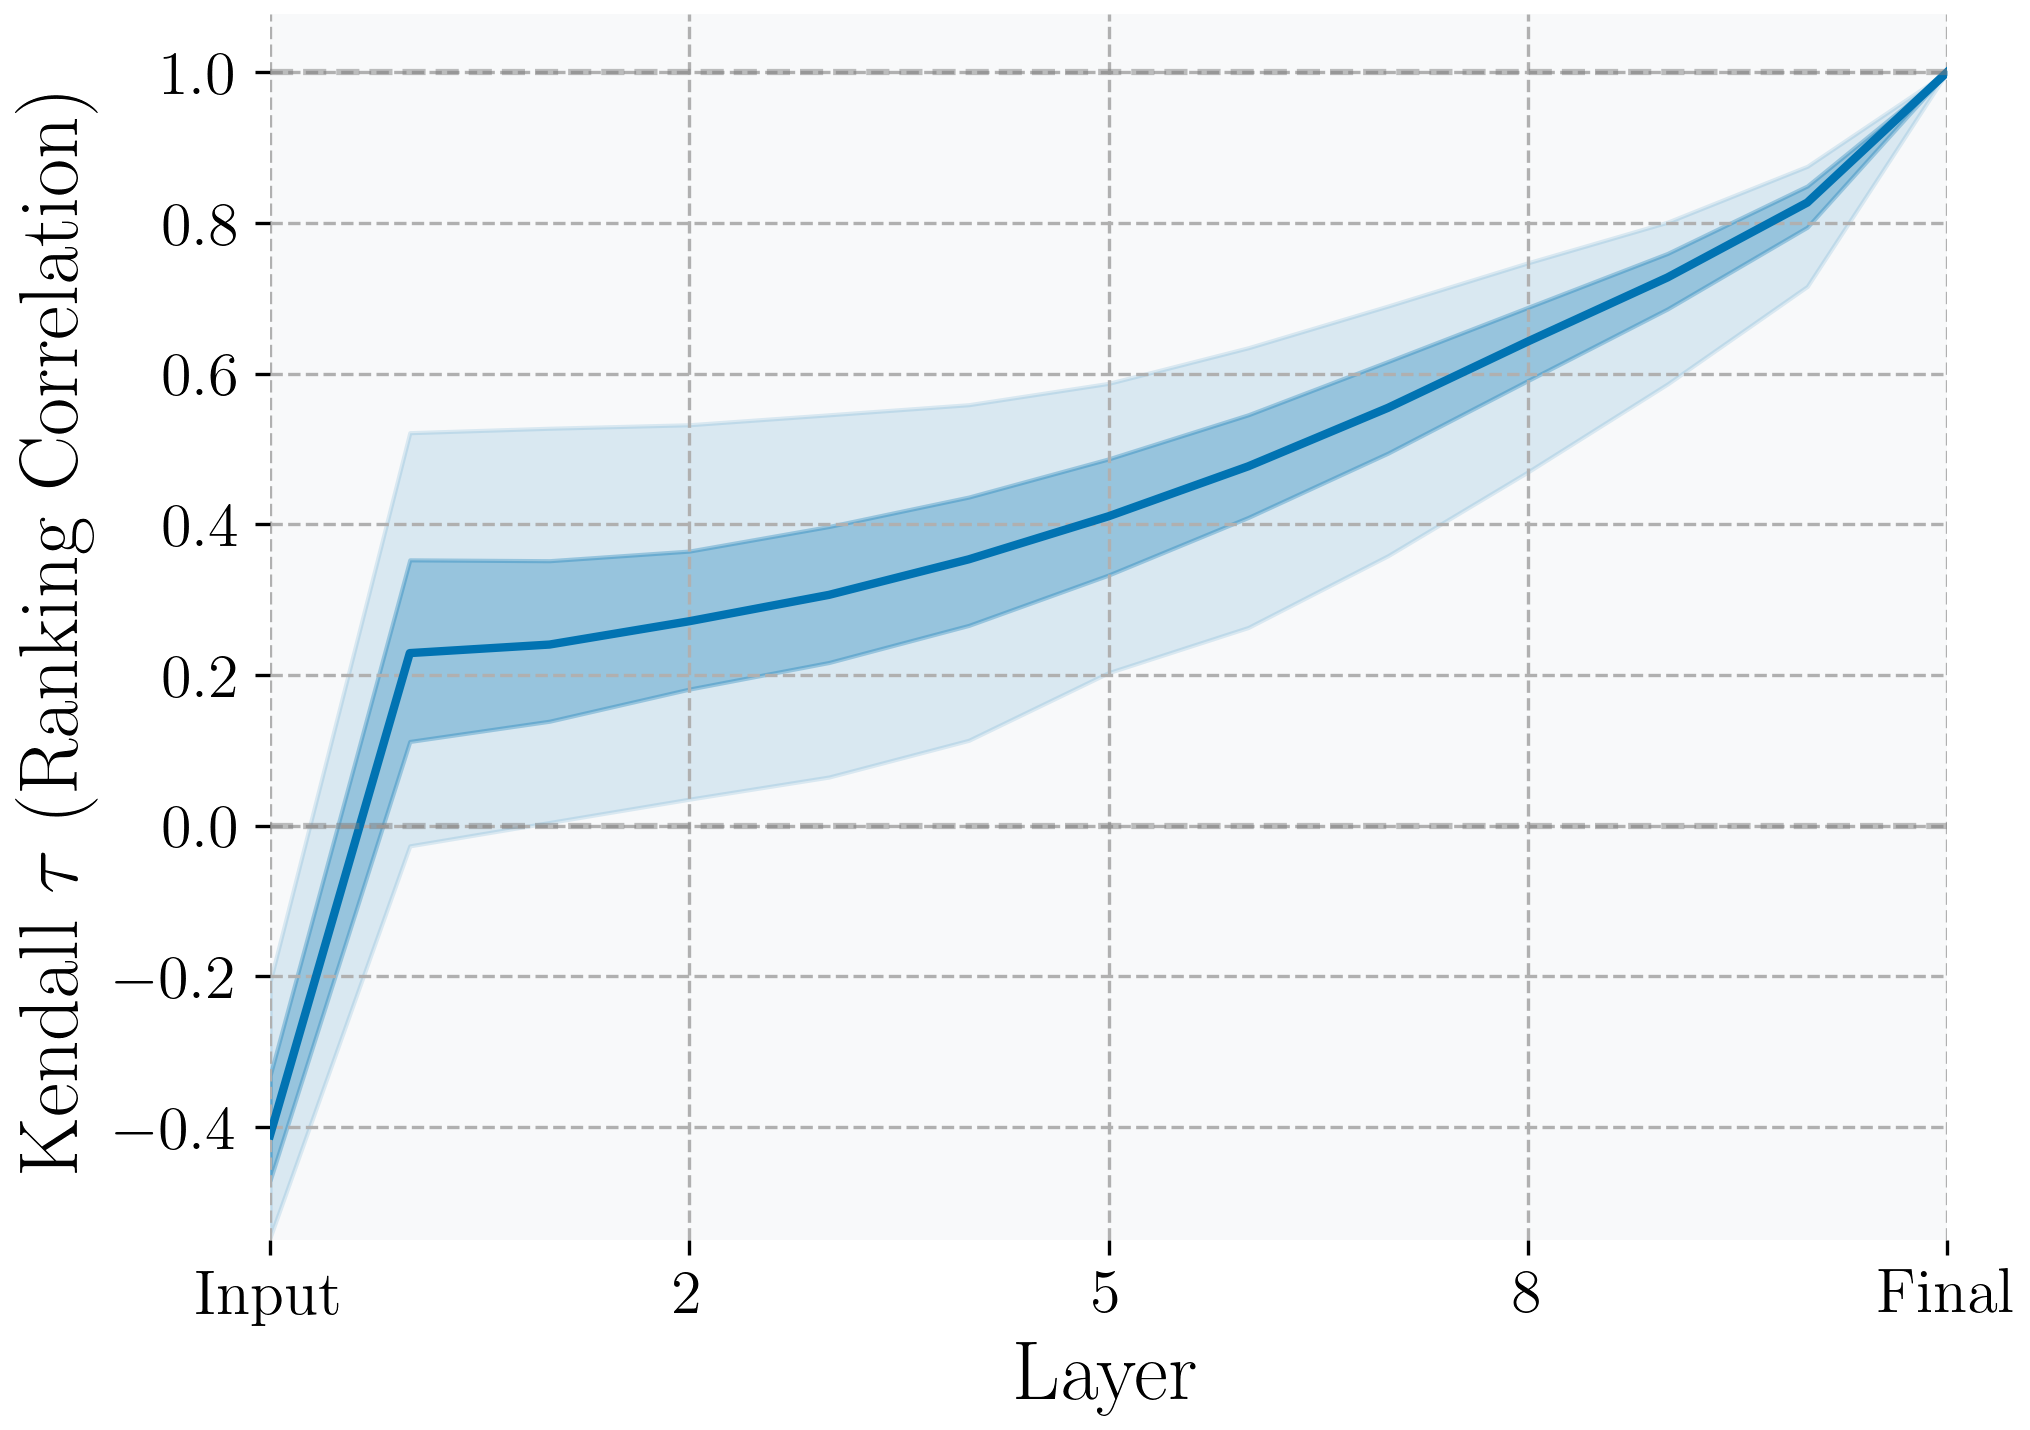

(<Figure size 2100x1500 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Kendall $\\tau$ (Ranking Correlation)'>)

In [259]:
plot_tau_metric_custom(
    data_array=gpt2_tau_data,
    save_path='Figures/gpt2_tau_correlation.pdf',
    reference_lines=[(0.0, 'gray', 0.5), (1.0, 'gray', 0.5)],
    ylim=(-0.55,None)
)

### GPT2-Large

In [260]:
gpt2_large_tau_data = analyze_single_model_tau(
    model_name='gpt2-large',
    dataset=dataset,
    datapoints=datapoints,
    device=device,
    top_k_filter=top_k_filter
)

=== Analyzing gpt2-large ===
  Processing sample 1/10
  Processing sample 2/10
  Processing sample 3/10
  Processing sample 4/10
  Processing sample 5/10
  Processing sample 6/10
  Processing sample 7/10
  Processing sample 8/10
  Processing sample 9/10
  Processing sample 10/10


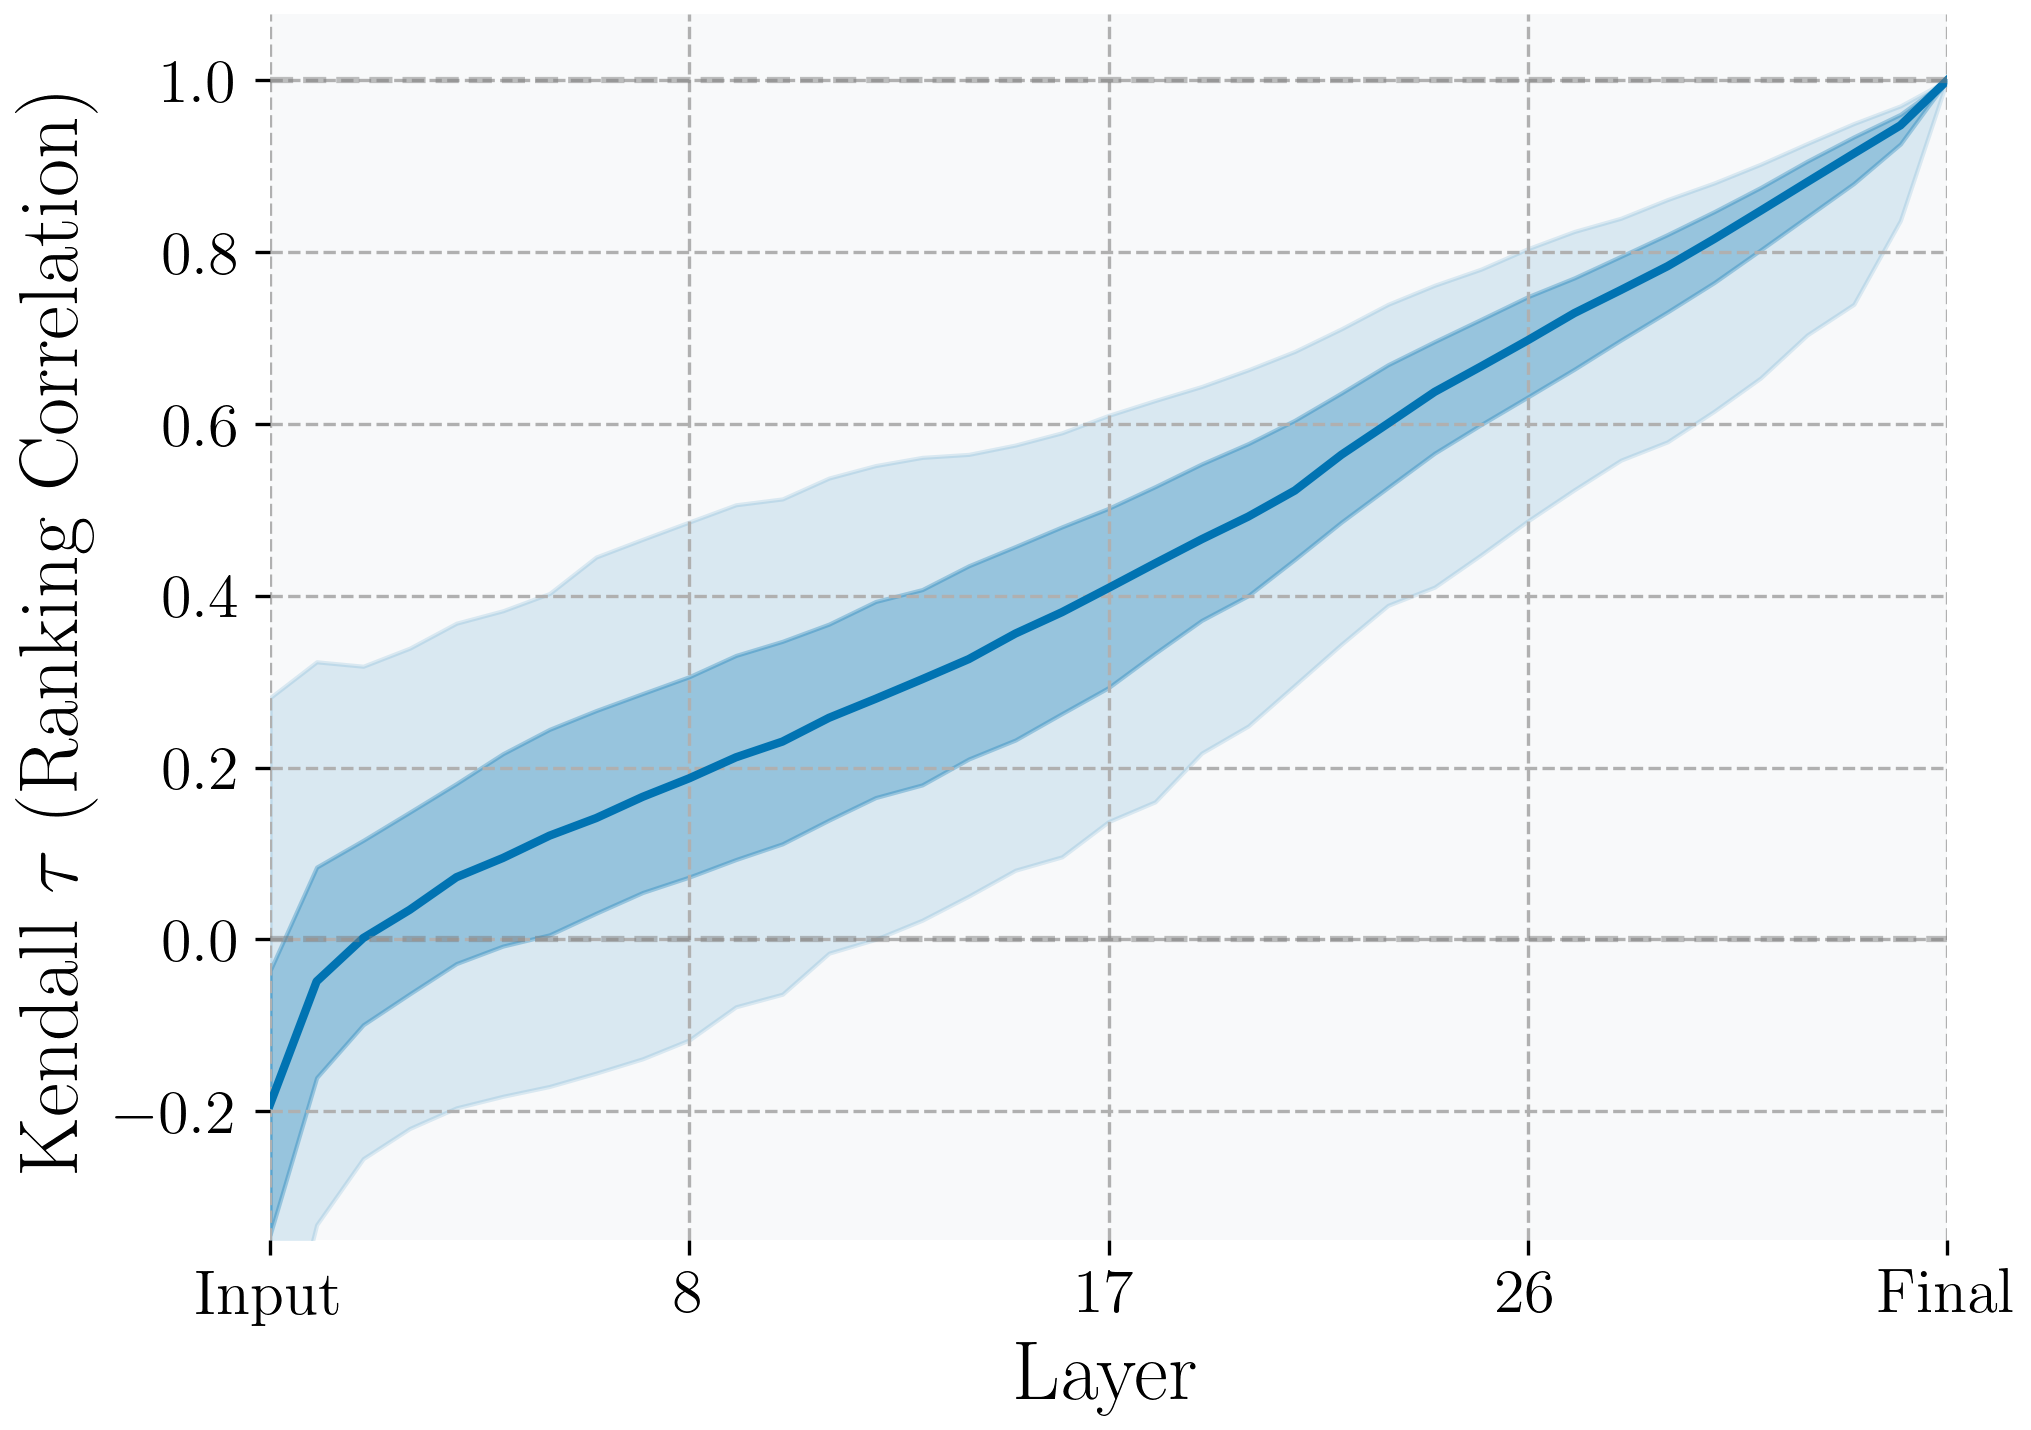

(<Figure size 2100x1500 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Kendall $\\tau$ (Ranking Correlation)'>)

In [261]:
plot_tau_metric_custom(
    data_array=gpt2_large_tau_data,
    save_path='Figures/gpt2_large_tau_correlation.pdf',
    reference_lines=[(0.0, 'gray', 0.5), (1.0, 'gray', 0.5)],
    ylim=(-0.35,None)
)

### GPT2-XL

In [262]:
gpt2_xl_tau_data = analyze_single_model_tau(
    model_name='gpt2-xl',
    dataset=dataset,
    datapoints=datapoints,
    device=device,
    top_k_filter=top_k_filter
)

=== Analyzing gpt2-xl ===
  Processing sample 1/10
  Processing sample 2/10
  Processing sample 3/10
  Processing sample 4/10
  Processing sample 5/10
  Processing sample 6/10
  Processing sample 7/10
  Processing sample 8/10
  Processing sample 9/10
  Processing sample 10/10


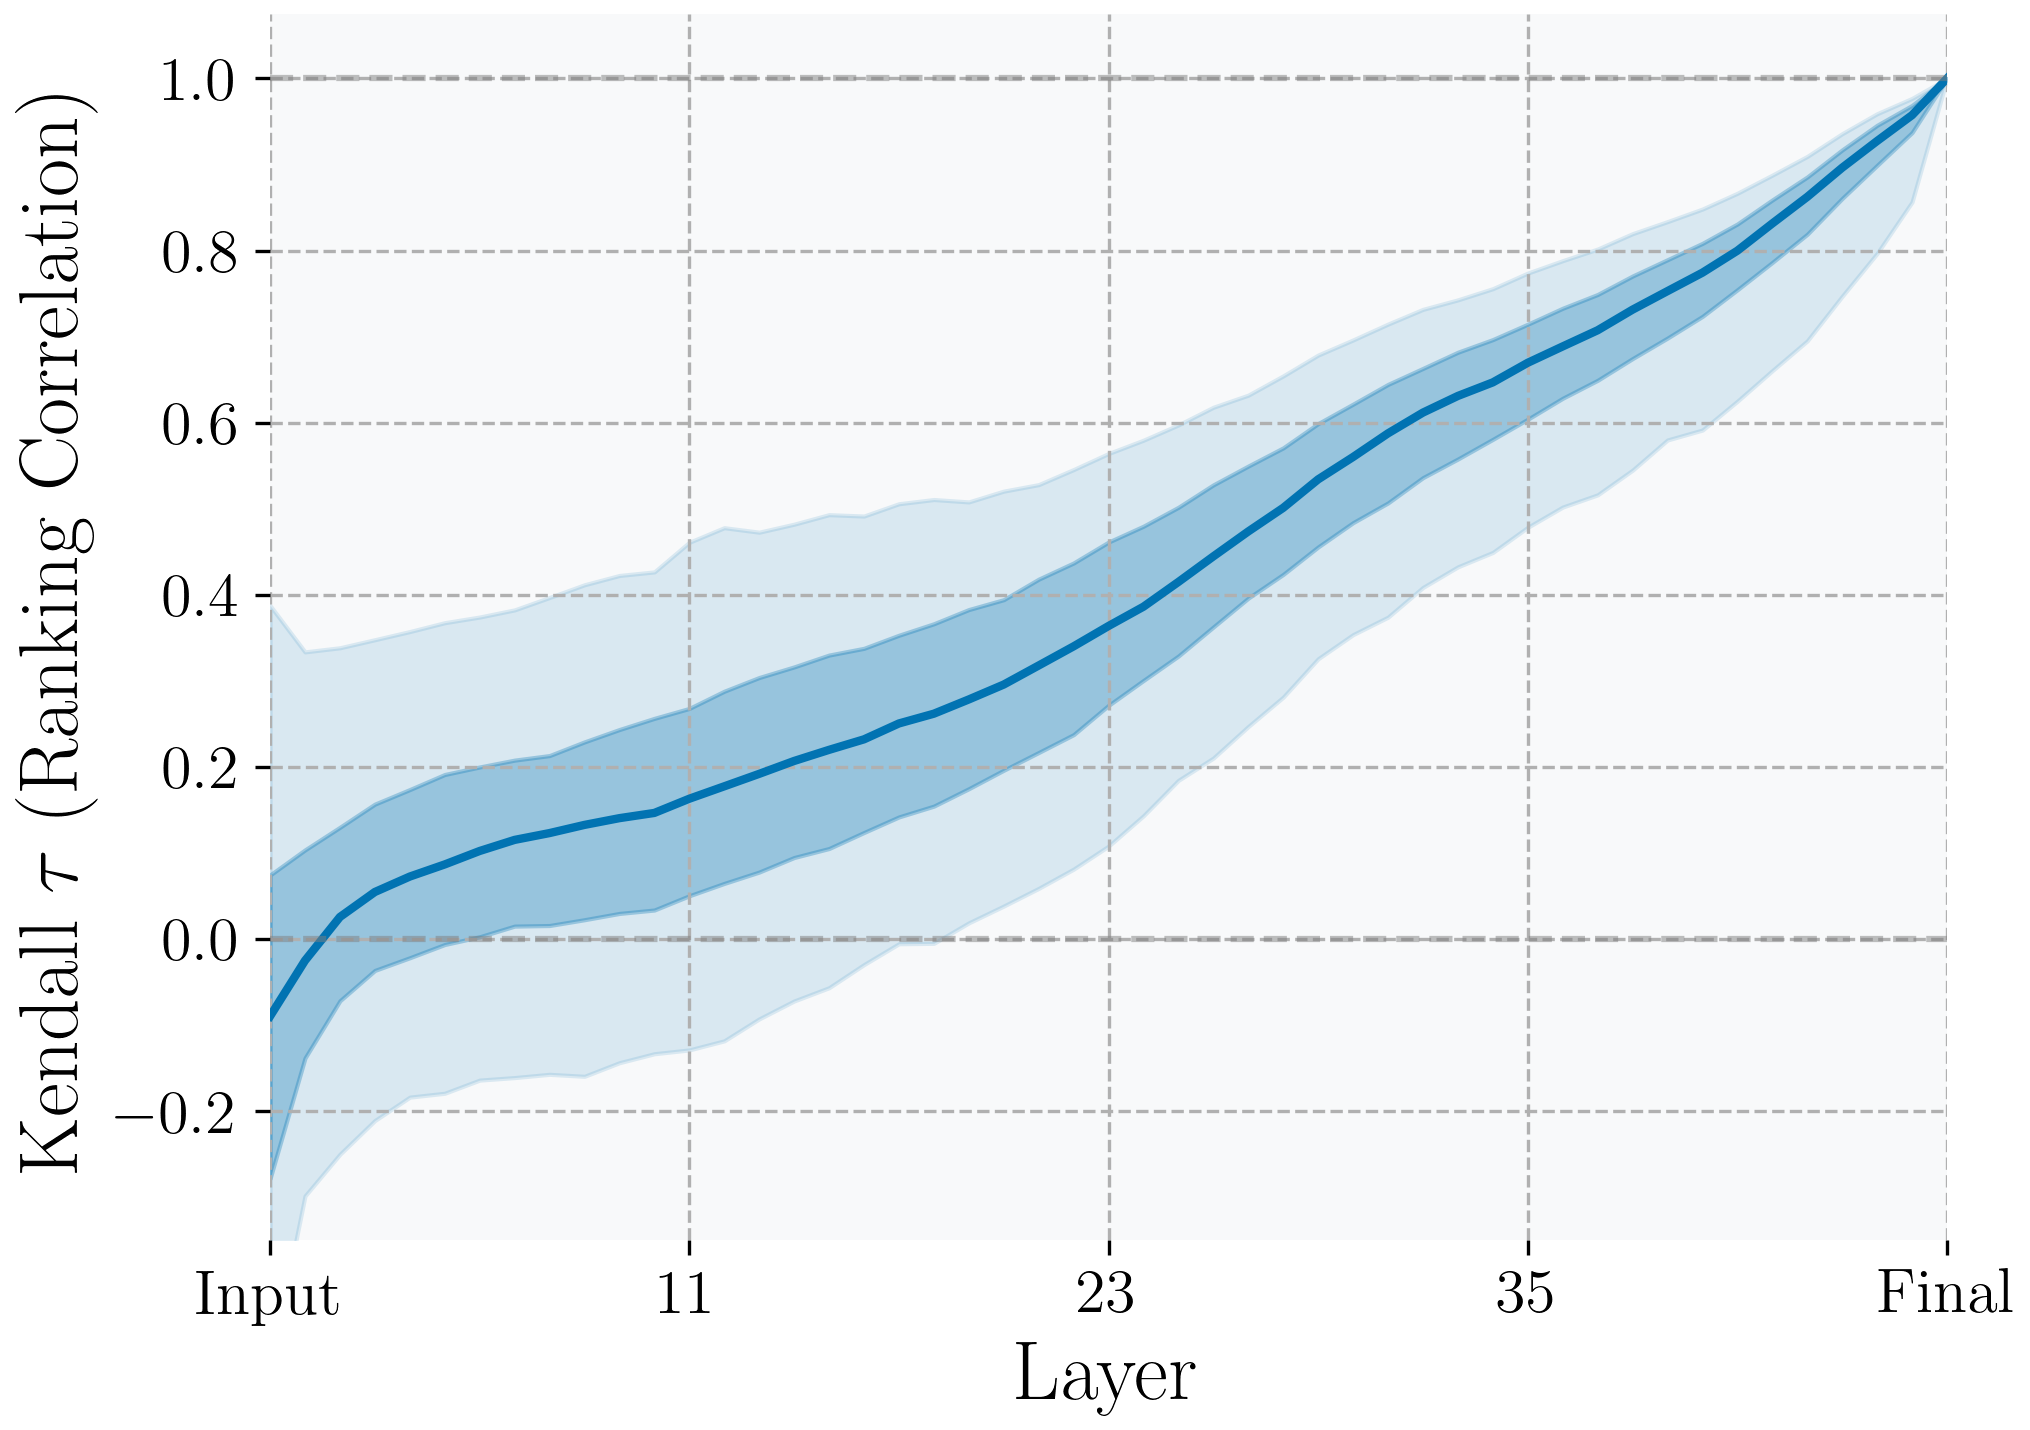

(<Figure size 2100x1500 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Kendall $\\tau$ (Ranking Correlation)'>)

In [263]:
plot_tau_metric_custom(
    data_array=gpt2_xl_tau_data,
    save_path='Figures/gpt2_xl_tau_correlation.pdf',
    reference_lines=[(0.0, 'gray', 0.5), (1.0, 'gray', 0.5)],
    ylim=(-0.35,None)
)

### Plot combined Kendalls $\tau$ for Leela and GPT2

In [301]:
# Make sure you're using consistent rcParams before plotting:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 22,
    "font.size": 11,
    "legend.fontsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "figure.figsize": (6, 4),
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05
})

In [306]:
def plot_combined_tau_comparison(gpt2_data, gpt2_large_data, gpt2_xl_data, chess_data, 
                                save_path="Figures/tau_comparison_all_models.pdf"):
    """
    Plot tau correlations for all models on a single figure.
    """
    
    # Model data and styling
    models_info = {
        'GPT-2': {'data': gpt2_data, 'color': COLORS[0]},
        'GPT-2 Large': {'data': gpt2_large_data, 'color': COLORS[1]},
        'GPT-2 XL': {'data': gpt2_xl_data, 'color': COLORS[2]},
        'Leela': {'data': chess_data, 'color': COLORS[3]}
    }
    
    # Create figure
    fig, ax = plt.subplots()
    
    # Plot each model
    for model_name, info in models_info.items():
        data = info['data']
        if len(data) == 0:
            continue
            
        # Compute median values
        median_vals = np.median(data, axis=0)
        num_layers = len(median_vals)
        
        # Use relative layer depth (0 to 1)
        x_values = np.linspace(0, 1, num_layers)
        
        # Plot median line
        ax.plot(x_values, median_vals, 
                color=info['color'], 
                linewidth=LINE_WIDTH,
                label=model_name)
    
    # Formatting
    ax.set_xlabel('Relative Layer Depth')
    ax.set_ylabel(r'Kendall $\tau$')# (Ranking Correlation)')
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.25, 1.05)
    
    # Y-axis formatting for correlation values
    ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
    
    # Styling
    ax.spines[:].set_visible(False)
    ax.set_facecolor(PLOT_FACE_COLOR)
    ax.grid(True, alpha=0.3, linestyle="--")
    
    # Reference lines
    ax.axhline(y=0.0, color='gray', linestyle='--', alpha=0.5)
    # ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    
    # Legend
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    return fig, ax

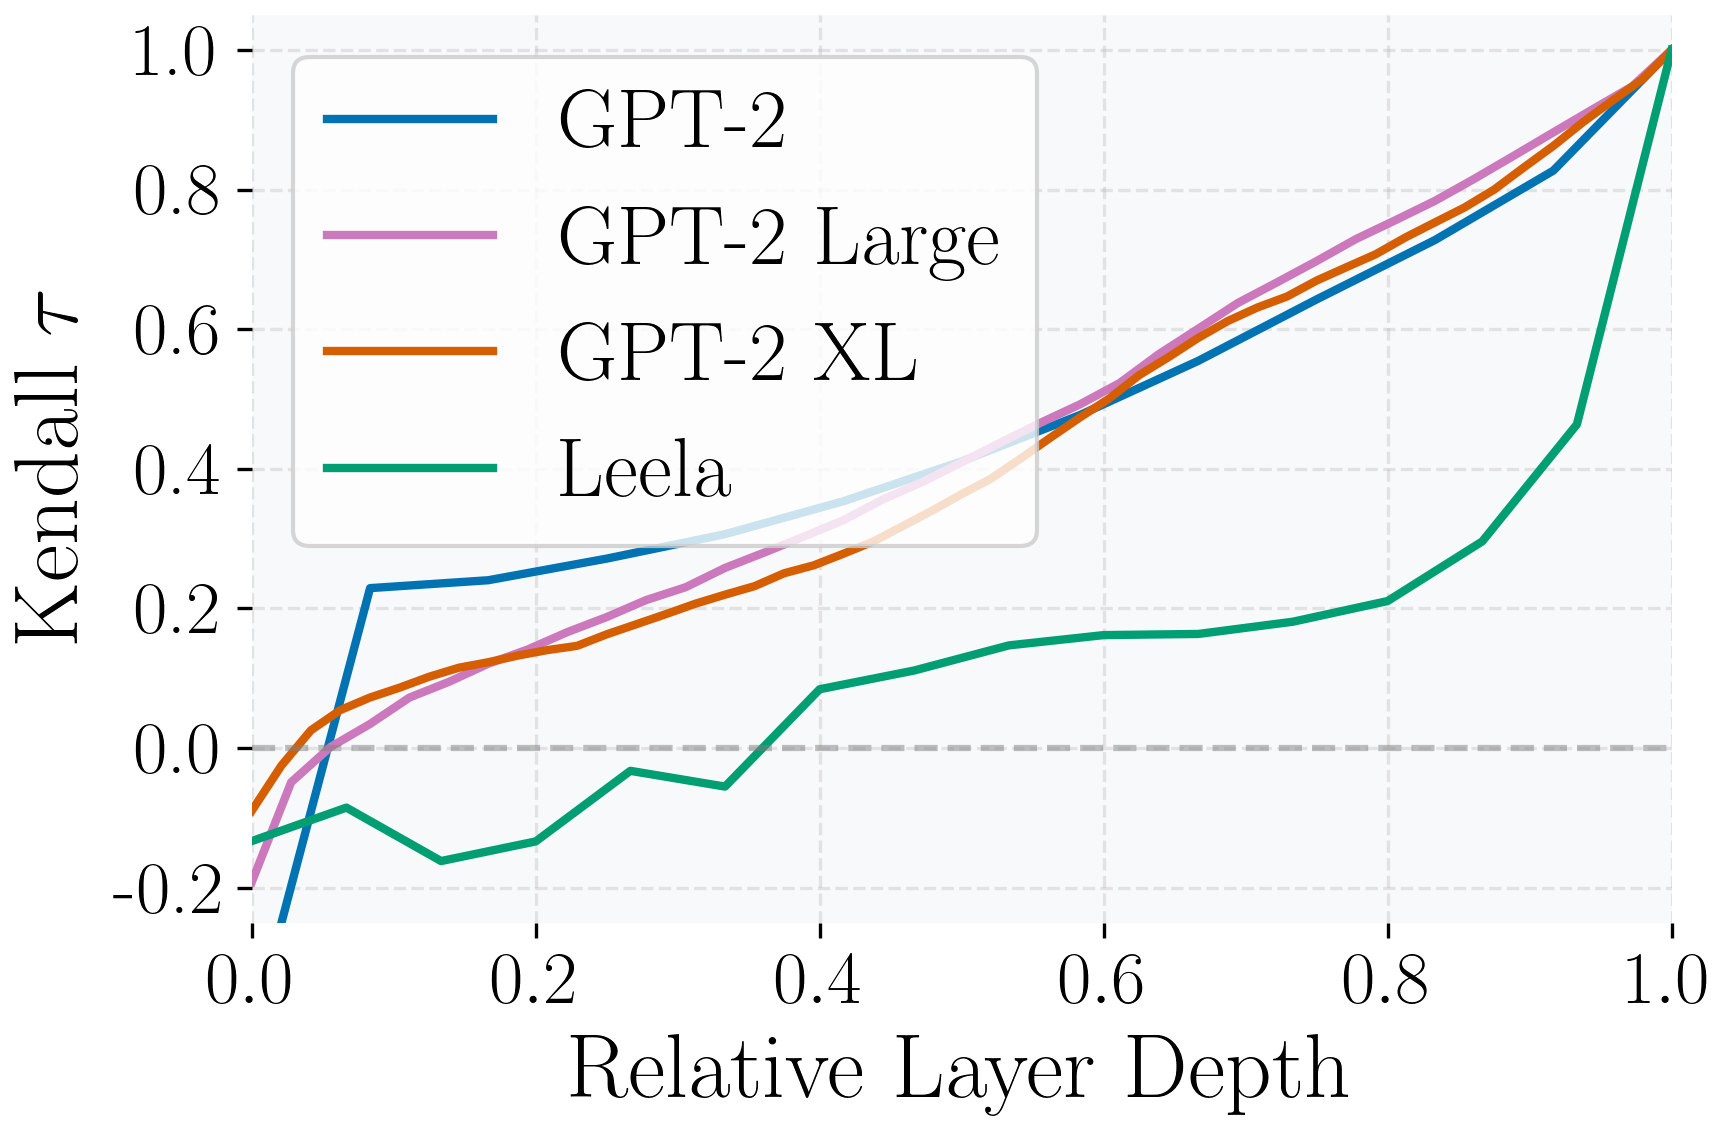

(<Figure size 1800x1200 with 1 Axes>,
 <Axes: xlabel='Relative Layer Depth', ylabel='Kendall $\\tau$'>)

In [307]:
plot_combined_tau_comparison(gpt2_tau_data, gpt2_large_tau_data, gpt2_xl_tau_data, tau_top5_data)